In [1]:
from pyarrow.parquet import ParquetFile
from torch.utils.data import *
import pyarrow as pa
import pyarrow.parquet as pq
import glob,os,re,time
import numpy as np
from multiprocessing import Pool
import pickle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mplhep as hep
import torch
import gc

plt.style.use([hep.style.ROOT, hep.style.firamath])
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [2]:
# ls /pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_tauDR0p4_m1p2To17p2_dataset_2_unbaised_v2_train/

In [3]:
## -------Excute this line only save certian data from parquet to pkl 


# class ParquetDataset(Dataset):
#     def __init__(self, filename, label):
#         self.parquet = pq.ParquetFile(filename)
#         self.cols = ['am','apt','m0']
#         self.label = label
#     def __getitem__(self, index):
#         data = self.parquet.read_row_group(index, columns=self.cols).to_pydict()
        
#         data['am'] = np.float32(data['am'])
#         data['apt'] = np.float32(data['apt'])
#         data['m0'] = np.float32(data['m0'])

#         return (data['am'],data['apt'],data['m0'])
#     def __len__(self):
#         return self.parquet.num_row_groups






# train_decays = glob.glob('/pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_tauDR0p4_m1p2To17p2_dataset_2_unbaised_v2_train/*')
# dset_train = ConcatDataset([ParquetDataset('%s'%d,i) for i,d in enumerate(train_decays)])
# n_eve = len(dset_train)
# print("Total events.  ", n_eve)
# mass, apt, mass0 = [], [], []
# for i, data in enumerate(dset_train):
#     am, pt, m0 = data[0], data[1], data[2]
#     mass.append(am)
#     apt.append(pt)
#     mass0.append(m0)
#     if i == 20001: break
#     if i % 100000 == 0:
#         print(f"processing event {i}")

# output_dict = {}
# output_dict["am"] = np.concatenate(mass, axis=0)
# output_dict["apt"] = np.concatenate(apt, axis=0)
# output_dict["m0"] = np.concatenate(mass0, axis=0)

# with open("%s/am_apt_data_for_plotting_unbiasing_status_.pkl" % os.environ['SCRATCH'], "wb") as outfile:
#     pickle.dump(output_dict, outfile, protocol=2)

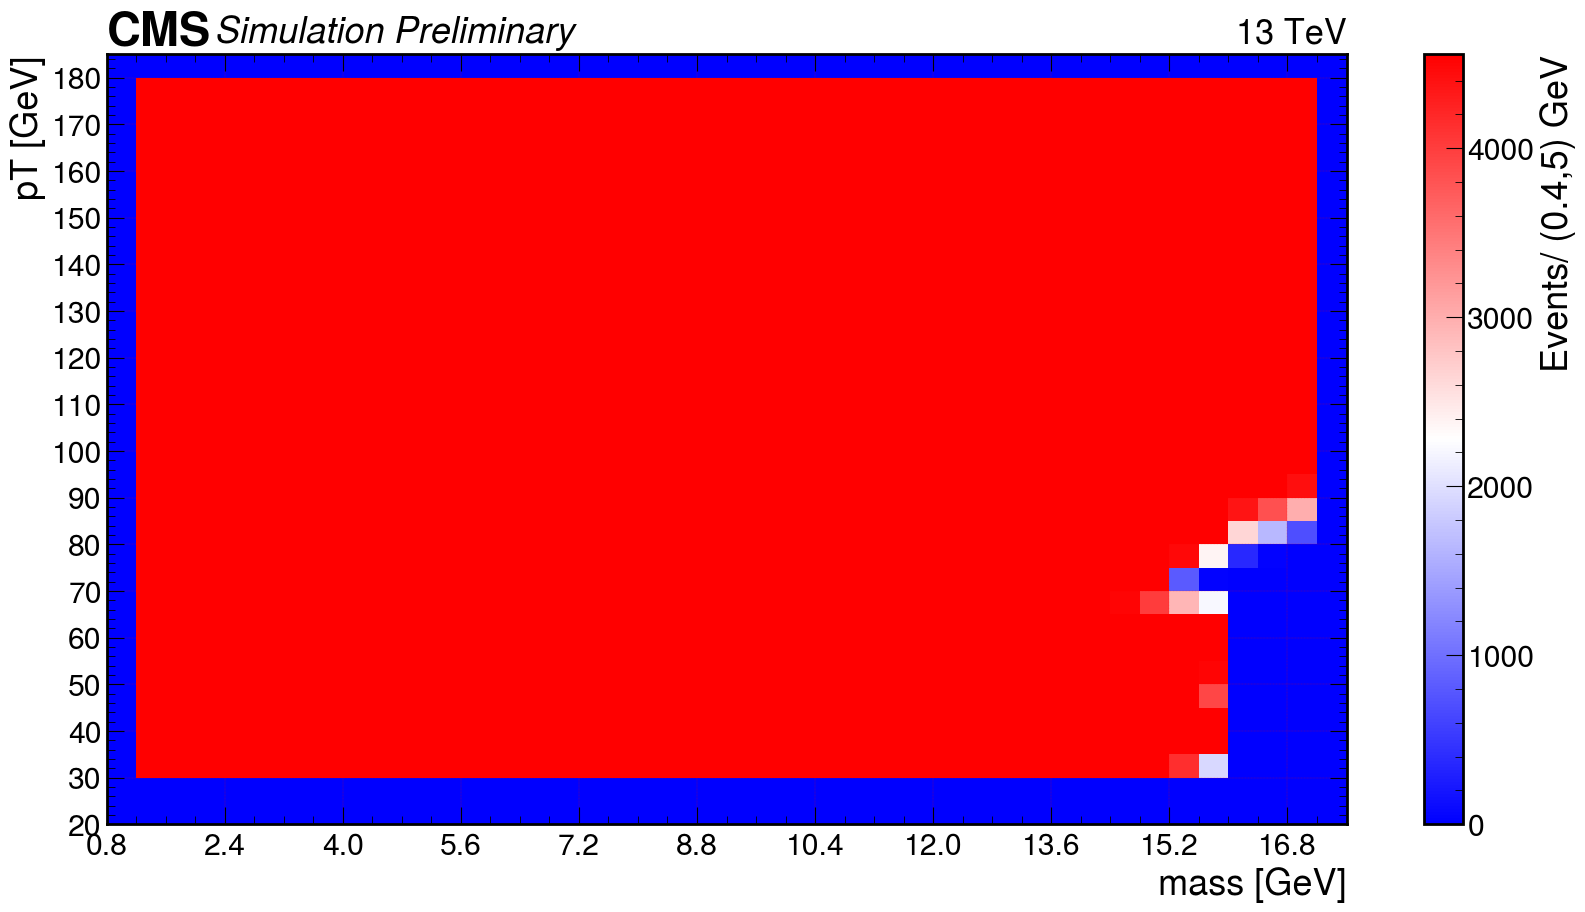

In [67]:
with open('%s/am_apt_data_for_plotting_unbiasing_status.pkl'%os.environ['SCRATCH'], 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    data = u.load()
am = data["am"]
apt = data["apt"]
fig, ax = plt.subplots(figsize=(20,10))
plt.hist2d(np.array(am).flatten(), np.array(apt).flatten(), bins=[np.arange(0.8,17.7,.4), np.arange(20,190,5)],cmap='bwr')
plt.xticks(np.arange(0.8,17.7, 1.6))
plt.yticks(np.arange(20,190,10))
plt.xlabel('mass [GeV]')
plt.ylabel('pT [GeV]')
plt.colorbar().set_label(label='Events/ (0.4,5) GeV')
plt.grid(color='r', linestyle='--', linewidth=.2)
hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
plt.savefig('m_original_pt_2D_hist.png',  bbox_inches='tight', dpi=300, facecolor = "w")
# plt.close()
plt.show()

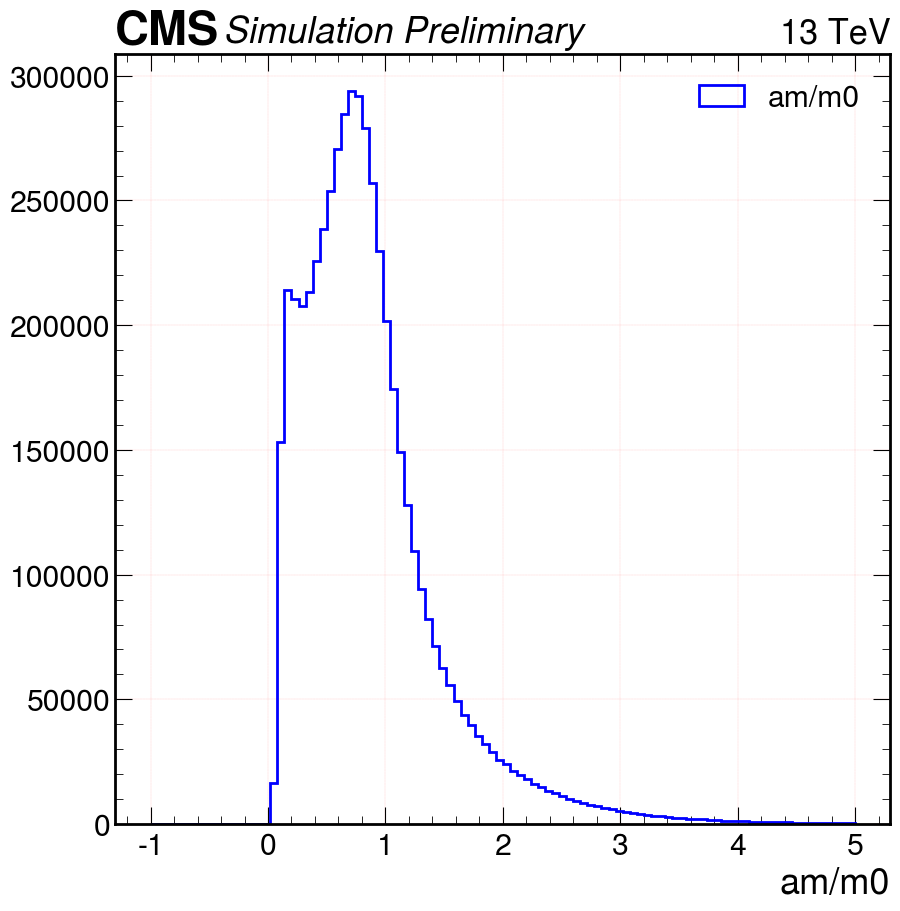

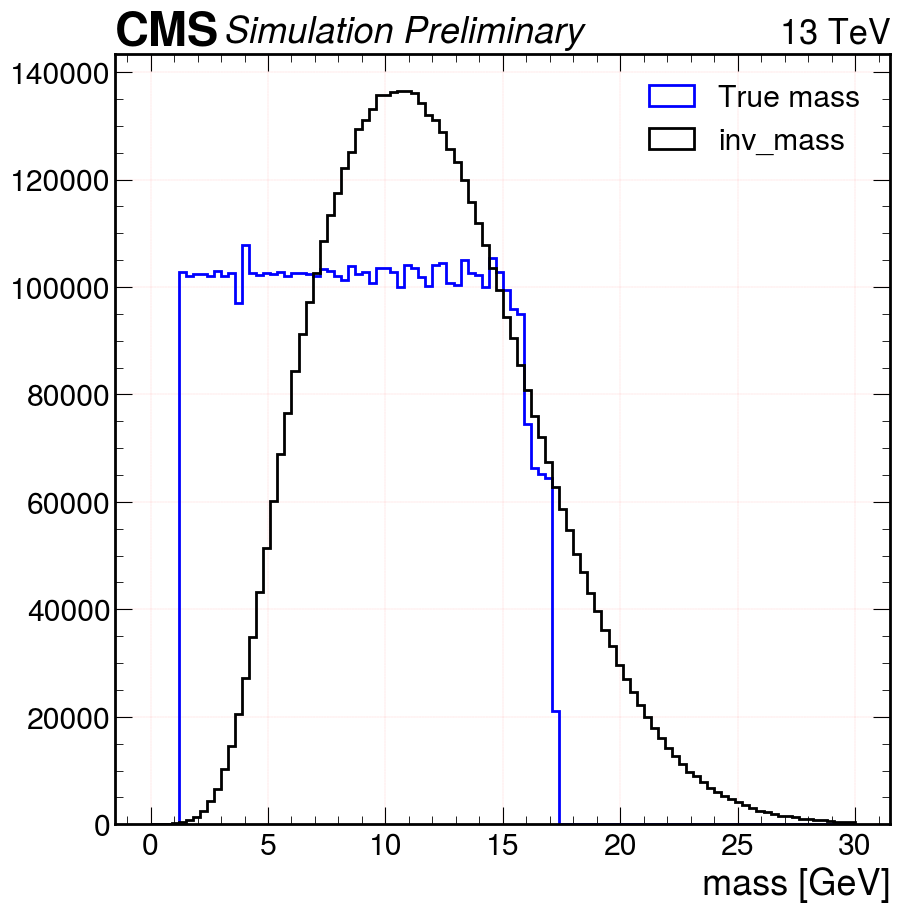

In [13]:
with open('%s/am_apt_data_for_plotting_unbiasing_status.pkl'%os.environ['SCRATCH'], 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    data = u.load()
am = data["am"]
m0 = data["m0"]
fig, ax = plt.subplots()
plt.hist(am/m0, range=(-1,5), histtype='step',bins=100, label='am/m0', linestyle='-', color='blue', linewidth=2)
plt.grid(color='r', linestyle='--', linewidth=.1)
plt.xlabel('am/m0')
# plt.title(r'$\mathrm{m_{true}}$, $\mathrm{m_{pred}}$ masses',size=25)
plt.legend(loc='best')
hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
# if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
plt.show()

fig, ax = plt.subplots()
plt.hist(am, histtype='step',range=(0,30),bins=100, label='True mass', linestyle='-', color='blue', linewidth=2)
plt.hist(m0, histtype='step',range=(0,30),bins=100, label='inv_mass', linestyle='-', color='black', linewidth=2)
plt.grid(color='r', linestyle='--', linewidth=.1)
plt.xlabel('mass [GeV]')
# plt.title(r'$\mathrm{m_{true}}$, $\mathrm{m_{pred}}$ masses',size=25)
plt.legend(loc='best')
hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
# if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
plt.show()

In [4]:
channel_list = ["Tracks_pt", "Tracks_dZSig", "Tracks_d0Sig", "ECAL_energy",
"HBHE_energy", "Pix_1", "Pix_2", "Pix_3", "Pix_4", "Tib_1", "Tib_2",
"Tib_3", "Tib_4", "Tob_1", "Tob_2", "Tob_3", "Tob_4", "Tob_5",
"Tob_6", "Tid_1", "Tec_1", "Tec_2", "Tec_3"]

### plot from scaled  data

In [2]:
def plot_scale_original(file1, file2, file3):
    bins = 100
    with open(file1, 'rb') as f1:
        u1 = pickle._Unpickler(f1)
        u1.encoding = 'latin1'
        data1 = u1.load()
    
    pt1 = data1["Traks_pt"]
    dz1 = data1["Tracks_dzsig"]
    d01 = data1["Tracks_d0sig"]
    ECAL_energy1 = data1["ECAL_energy"]
    HBHE_energy1 = data1["HBHE_energy"]
    Pix_11 = data1["Pix_1"]
    Pix_21 = data1["Pix_2"]
    Pix_31 = data1["Pix_3"]
    Pix_41 = data1["Pix_4"]
    Tib_11 = data1["Tib_1"]
    Tib_21 = data1["Tib_2"]
    Tob_11 = data1["Tob_1"]
    Tob_21 = data1["Tob_2"]

    with open(file2, 'rb') as f2:
        u2 = pickle._Unpickler(f2)
        u2.encoding = 'latin1'
        data2 = u2.load()
    
    pt2 = data2["Traks_pt"]
    dz2 = data2["Tracks_dzsig"]
    d02 = data2["Tracks_d0sig"]
    ECAL_energy2 = data2["ECAL_energy"]
    HBHE_energy2 = data2["HBHE_energy"]
    Pix_12 = data2["Pix_1"]
    Pix_22 = data2["Pix_2"]
    Pix_32 = data2["Pix_3"]
    Pix_42 = data2["Pix_4"]
    Tib_12 = data2["Tib_1"]
    Tib_22 = data2["Tib_2"]
    Tob_12 = data2["Tob_1"]
    Tob_22 = data2["Tob_2"]
    
    
    with open(file3, 'rb') as f3:
        u3 = pickle._Unpickler(f3)
        u3.encoding = 'latin1'
        data3 = u3.load()
    
    pt3 = data3["Traks_pt"]
    dz3 = data3["Tracks_dzsig"]
    d03 = data3["Tracks_d0sig"]
    ECAL_energy3 = data3["ECAL_energy"]
    HBHE_energy3 = data3["HBHE_energy"]
    Pix_13 = data3["Pix_1"]
    Pix_23 = data3["Pix_2"]
    Pix_33 = data3["Pix_3"]
    Pix_43 = data3["Pix_4"]
    Tib_13 = data3["Tib_1"]
    Tib_23 = data3["Tib_2"]
    Tob_13 = data3["Tob_1"]
    Tob_23 = data3["Tob_2"]
    
    # pre-scaling
    
#     pt_scale    = 0.2    
#     ecal_scale  = 0.2   
#     hcal_scale  = 1
#     dz_scale    = 0.1
#     d0_scale    = 0.05
#     pix_scale = 0.1
#     tracker_scale = 0.05
    
#     pt1[pt1 > 5] = 0
#     ECAL_energy1[ECAL_energy1 > 5] = 0
#     HBHE_energy1[HBHE_energy1 > 1] =0
#     dz1[abs(dz1) > 10] = 0
#     d01[abs(d01) > 20] = 0
#     Pix_11[Pix_11>10] =0
#     Pix_21[Pix_21>10] =0
#     Pix_31[Pix_31>10] =0
#     Pix_41[Pix_41>10] =0
#     Tib_11[Tib_11 > 20] =0
#     Tib_21[Tib_21 > 20] =0 
#     Tob_11[Tob_11 > 20] =0
#     Tob_21[Tob_21 > 20] =0 


#     pt1=pt_scale*pt1
#     dz1 = dz_scale*dz1
#     d01 = d0_scale*d01
#     ECAL_energy1 = ecal_scale*ECAL_energy1
#     HBHE_energy1 = hcal_scale*HBHE_energy1
#     Pix_11 = pix_scale*Pix_11
#     Pix_21 = pix_scale*Pix_21
#     Pix_31 = pix_scale*Pix_31
#     Pix_41 = pix_scale*Pix_41
#     Tib_11 = tracker_scale*Tib_11
#     Tib_21 = tracker_scale*Tib_21
#     Tob_11 = tracker_scale*Tob_11
#     Tob_21 = tracker_scale*Tob_21
    
#     pt2[pt2 > 5] = 0
#     ECAL_energy2[ECAL_energy2 > 5] = 0
#     HBHE_energy2[HBHE_energy2 > 1] =0
#     dz2[abs(dz2) > 10] = 0
#     d02[abs(d02) > 20] = 0
#     Pix_12[Pix_12>10] =0
#     Pix_22[Pix_22>10] =0
#     Pix_32[Pix_32>10] =0
#     Pix_42[Pix_42>10] =0
#     Tib_12[Tib_12 > 20] =0
#     Tib_22[Tib_22 > 20] =0 
#     Tob_12[Tob_12 > 20] =0
#     Tob_22[Tob_22 > 20] =0 


#     pt2=pt_scale*pt2
#     dz2 = dz_scale*dz2
#     d02 = d0_scale*d02
#     ECAL_energy2 = ecal_scale*ECAL_energy2
#     HBHE_energy2 = hcal_scale*HBHE_energy2
#     Pix_12 = pix_scale*Pix_12
#     Pix_22 = pix_scale*Pix_22
#     Pix_32 = pix_scale*Pix_32
#     Pix_42 = pix_scale*Pix_42
#     Tib_12 = tracker_scale*Tib_12
#     Tib_22 = tracker_scale*Tib_21
#     Tob_12 = tracker_scale*Tob_12
#     Tob_22 = tracker_scale*Tob_22
    
#     pt3[pt3 > 5] = 0
#     ECAL_energy3[ECAL_energy3 > 5] = 0
#     HBHE_energy3[HBHE_energy3 > 1] =0
#     dz3[abs(dz3) > 10] = 0
#     d03[abs(d03) > 20] = 0
#     Pix_13[Pix_13>10] =0
#     Pix_23[Pix_23>10] =0
#     Pix_33[Pix_33>10] =0
#     Pix_43[Pix_43>10] =0
#     Tib_13[Tib_13 > 20] =0
#     Tib_23[Tib_23 > 20] =0 
#     Tob_13[Tob_13 > 20] =0
#     Tob_23[Tob_23 > 20] =0 


#     pt3=pt_scale*pt3
#     dz3 = dz_scale*dz3
#     d03 = d0_scale*d03
#     ECAL_energy3 = ecal_scale*ECAL_energy3
#     HBHE_energy3 = hcal_scale*HBHE_energy3
#     Pix_13 = pix_scale*Pix_13
#     Pix_23 = pix_scale*Pix_23
#     Pix_33 = pix_scale*Pix_33
#     Pix_43 = pix_scale*Pix_43
#     Tib_13 = tracker_scale*Tib_13
#     Tib_23 = tracker_scale*Tib_23
#     Tob_13 = tracker_scale*Tob_13
#     Tob_23 = tracker_scale*Tob_23

    
    
    
    
    
    

    fig, ax = plt.subplots()
    plt.hist(pt1, histtype='step', range=(0,200),log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
    plt.hist(pt2, histtype='step', range=(0,200),log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
    plt.hist(pt3, histtype='step', range=(0,200),log=True,bins=bins, label='m=4.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('Tracks_pt')
    plt.legend(loc='best')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(dz1, histtype='step',range=(-5000,5000),log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
    plt.hist(dz2, histtype='step',log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
    plt.hist(dz3, histtype='step',log=True,bins=bins, label='m=14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('Tracks_dzsig')
    plt.legend(loc='best')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(d01, histtype='step', range=(-2000,2000), log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
    plt.hist(d02, histtype='step', log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
    plt.hist(d03, histtype='step', log=True,bins=bins, label='m=14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('Tracks_d0sig')
    plt.legend(loc='best')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(ECAL_energy1, histtype='step', log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
    plt.hist(ECAL_energy2, histtype='step', log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
    plt.hist(ECAL_energy3, histtype='step', log=True,bins=bins, label='m= 14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('ECAL_energy')
    plt.legend(loc='best')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(HBHE_energy1, histtype='step', log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
    plt.hist(HBHE_energy2, histtype='step', log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
    plt.hist(HBHE_energy3, histtype='step', log=True,bins=bins, label='m=14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('HBHE_energy')
    plt.legend(loc='best')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(Pix_11, histtype='step', log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
    plt.hist(Pix_12, histtype='step', log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
    plt.hist(Pix_13, histtype='step', log=True,bins=bins, label='m=14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('Pix_1')
    plt.legend(loc='best')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(Pix_21, histtype='step',log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
    plt.hist(Pix_22, histtype='step',log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
    plt.hist(Pix_23, histtype='step',log=True,bins=bins, label='m=14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('Pix_2')
    plt.legend(loc='best')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(Pix_31, histtype='step', log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
    plt.hist(Pix_32, histtype='step', log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
    plt.hist(Pix_33, histtype='step', log=True,bins=bins, label='m=14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('Pix_3')
    plt.legend(loc='best')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(Pix_41, histtype='step', log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
    plt.hist(Pix_42, histtype='step', log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
    plt.hist(Pix_43, histtype='step', log=True,bins=bins, label='m=14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('Pix_4')
    plt.legend(loc='best')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(Tib_11, histtype='step', log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
    plt.hist(Tib_12, histtype='step', log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
    plt.hist(Tib_13, histtype='step', log=True,bins=bins, label='m=14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('Tib_1')
    plt.legend(loc='best')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(Tib_21, histtype='step', log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
    plt.hist(Tib_22, histtype='step', log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
    plt.hist(Tib_23, histtype='step', log=True,bins=bins, label='m=14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('Tib_2')
    plt.legend(loc='best')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(Tob_11, histtype='step', log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
    plt.hist(Tob_12, histtype='step', log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
    plt.hist(Tob_13, histtype='step', log=True,bins=bins, label='m=14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('Tob_1')
    plt.legend(loc='best')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(Tob_21, histtype='step', log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
    plt.hist(Tob_22, histtype='step', log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
    plt.hist(Tob_23, histtype='step', log=True,bins=bins, label='m=14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('Tob_2')
    plt.legend(loc='best')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()
    gc.collect()


In [3]:
# ## -------Excute this line only save certian data from parquet to pkl 
# class ParquetDataset(Dataset):
#     def __init__(self, filename, label):
#         self.parquet = pq.ParquetFile(filename)
#         self.cols = ['X_jet.list.item.list.item.list.item']
#         self.label = label
#     def __getitem__(self, index):
#          data = self.parquet.read_row_group(index, columns=self.cols).to_pydict()
        
#          data['X_jet'] = np.float32(data['X_jet'][0])

#          return data['X_jet']
#     def __len__(self):
#         return self.parquet.num_row_groups
# train_decays = glob.glob('/pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_tauDR0p4_m1p2To17p2_dataset_2_unbaised_v2_valid/*m14To17p2*')
# dset_train = ConcatDataset([ParquetDataset('%s'%d,i) for i,d in enumerate(train_decays)])
# n_eve = len(dset_train)
# print("Total events.  ", n_eve)

# idxs_train = np.random.permutation(10000)


# print('used events ', len(idxs_train))
# Tracks_pt, Tracks_dzsig, Tracks_d0sig,ECAL_energy, HBHE_energy, Pix_1, Pix_2, Pix_3, Pix_4,Tib_1, Tib_2, Tob_1, Tob_2 = [], [], [],[],[],[],[],[],[],[],[],[],[]
# for j,i in enumerate(idxs_train):
#     data = dset_train[i]
#     pt, dz, d0, Ecal, Hcal, Pix1, Pix2, Pix3, Pix4,Tib1, Tib2, Tob1,Tob2 = data[0].flatten(), data[1].flatten(), data[2].flatten(),data[3].flatten(),data[4].flatten(),data[5].flatten(),data[6].flatten(),data[7].flatten(),data[8].flatten(),data[9].flatten(),data[10].flatten(),data[11].flatten(),data[12].flatten()
#     Tracks_pt.append(pt)
#     Tracks_dzsig.append(dz)
#     Tracks_d0sig.append(d0)
#     ECAL_energy.append(Ecal)
#     HBHE_energy.append(Hcal)
#     Pix_1.append(Pix1)
#     Pix_2.append(Pix2)
#     Pix_3.append(Pix3)
#     Pix_4.append(Pix4)
#     Tib_1.append(Tib1)
#     Tib_2.append(Tib2)
#     Tob_1.append(Tob1)
#     Tob_2.append(Tob2)
#     if j % 1000 == 0:
#         print(f"processing event {j} with actual event {i}")

# output_dict = {}
# print("wriring to output file")
# output_dict["Traks_pt"] = np.concatenate(Tracks_pt, axis=0)
# output_dict["Tracks_dzsig"] = np.concatenate(Tracks_dzsig, axis=0)
# output_dict["Tracks_d0sig"] = np.concatenate(Tracks_d0sig, axis=0)
# output_dict["ECAL_energy"] = np.concatenate(ECAL_energy, axis=0)
# output_dict["HBHE_energy"] = np.concatenate( HBHE_energy, axis=0)
# output_dict["Pix_1"] = np.concatenate(Pix_1, axis=0)
# output_dict["Pix_2"] = np.concatenate(Pix_2, axis=0)
# output_dict["Pix_3"] = np.concatenate(Pix_3, axis=0)
# output_dict["Pix_4"] = np.concatenate(Pix_4, axis=0)
# output_dict["Tib_1"] = np.concatenate(Tib_1, axis=0)
# output_dict["Tib_2"] = np.concatenate(Tib_2, axis=0)
# output_dict["Tob_1"] = np.concatenate(Tob_1, axis=0)
# output_dict["Tob_2"] = np.concatenate(Tob_2, axis=0)

# with open("%s/massreg_all_layers_data_to_check_scaling_m14To17p2.pkl" % os.environ['SCRATCH'], "wb") as outfile:
#     pickle.dump(output_dict, outfile, protocol=2)

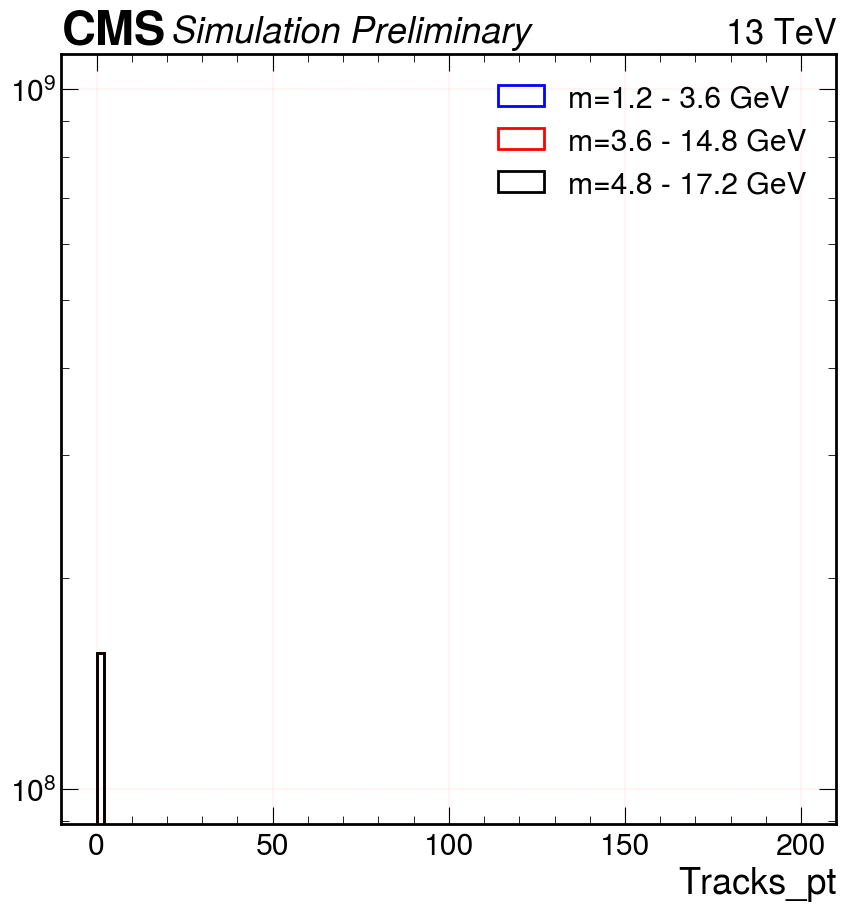

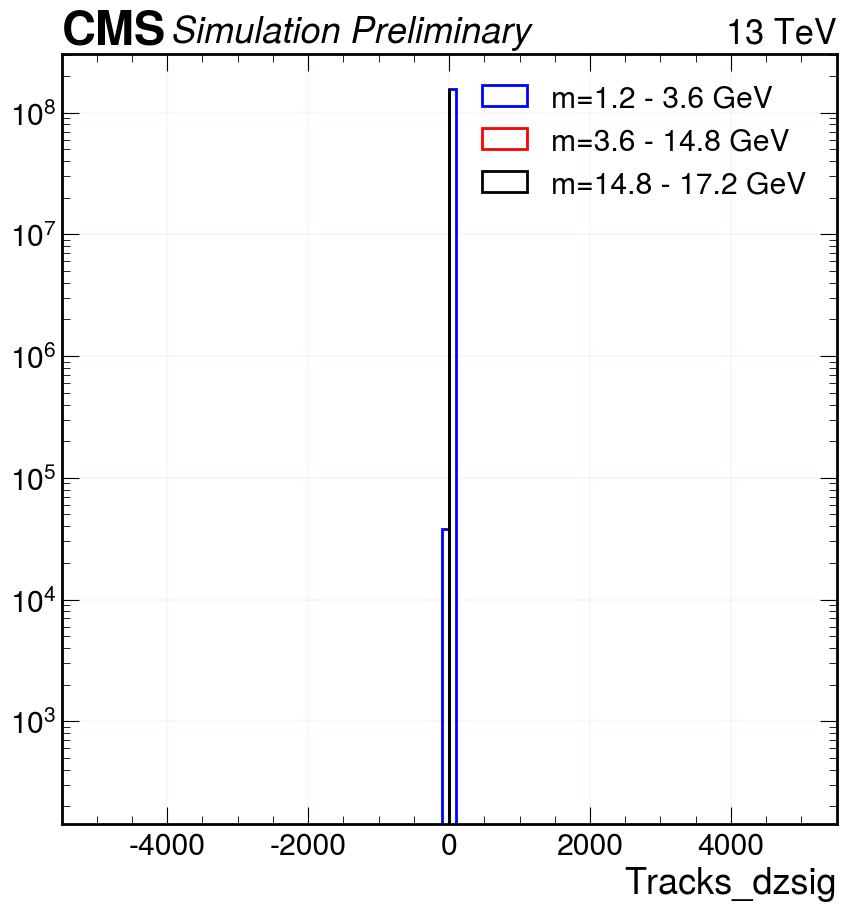

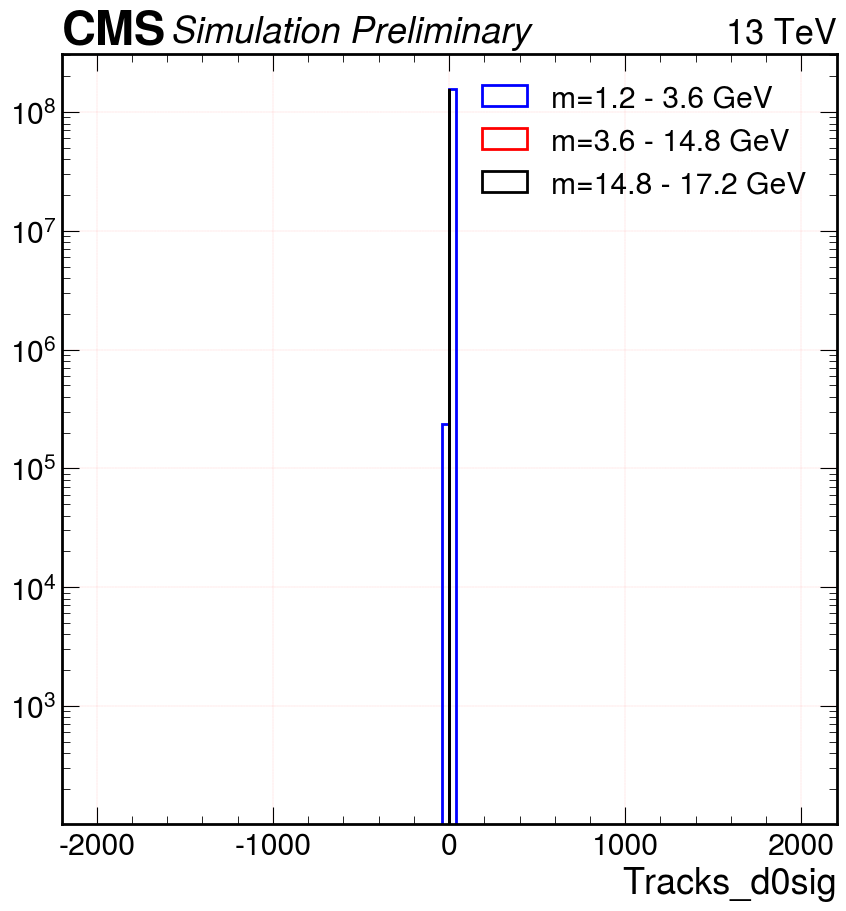

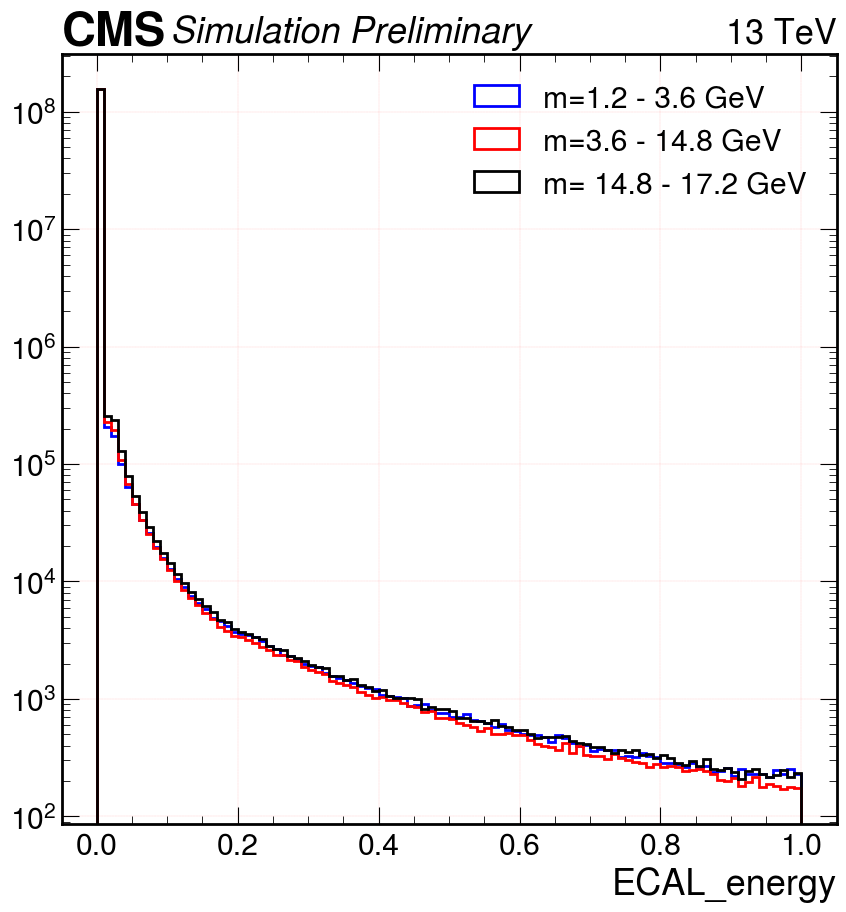

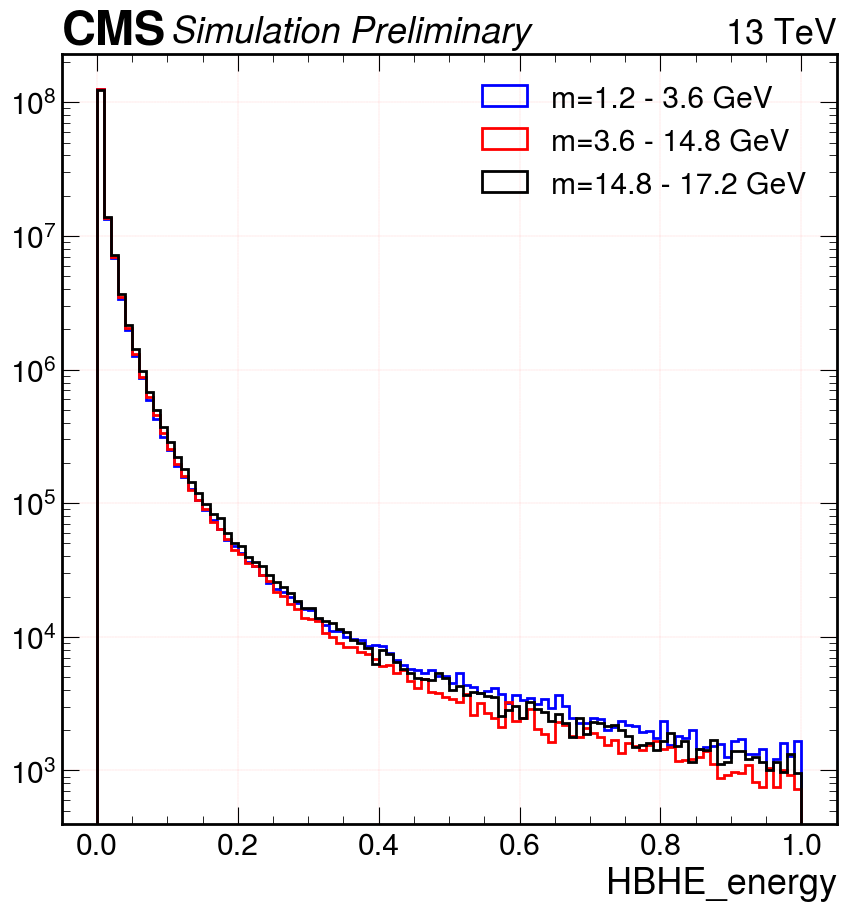

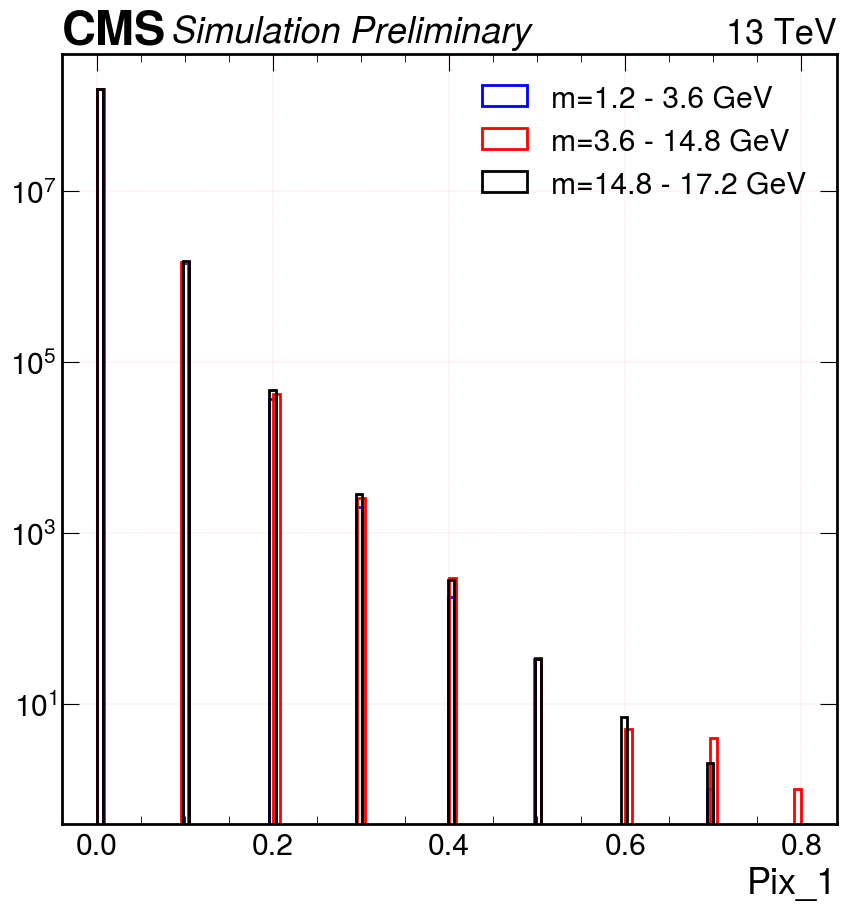

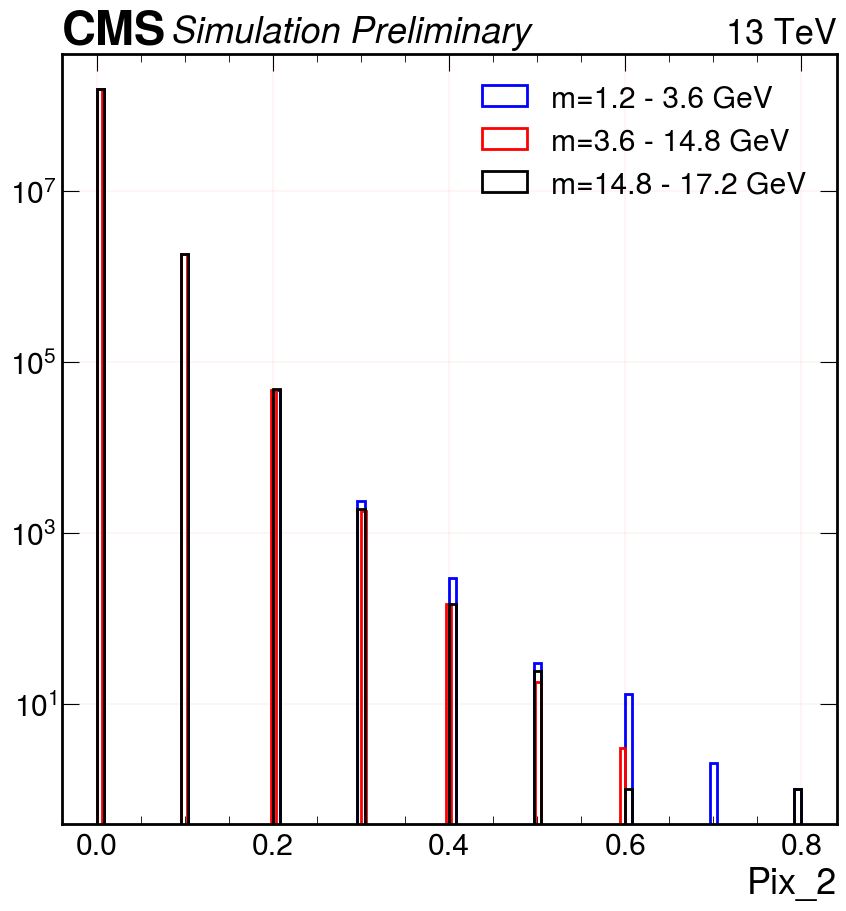

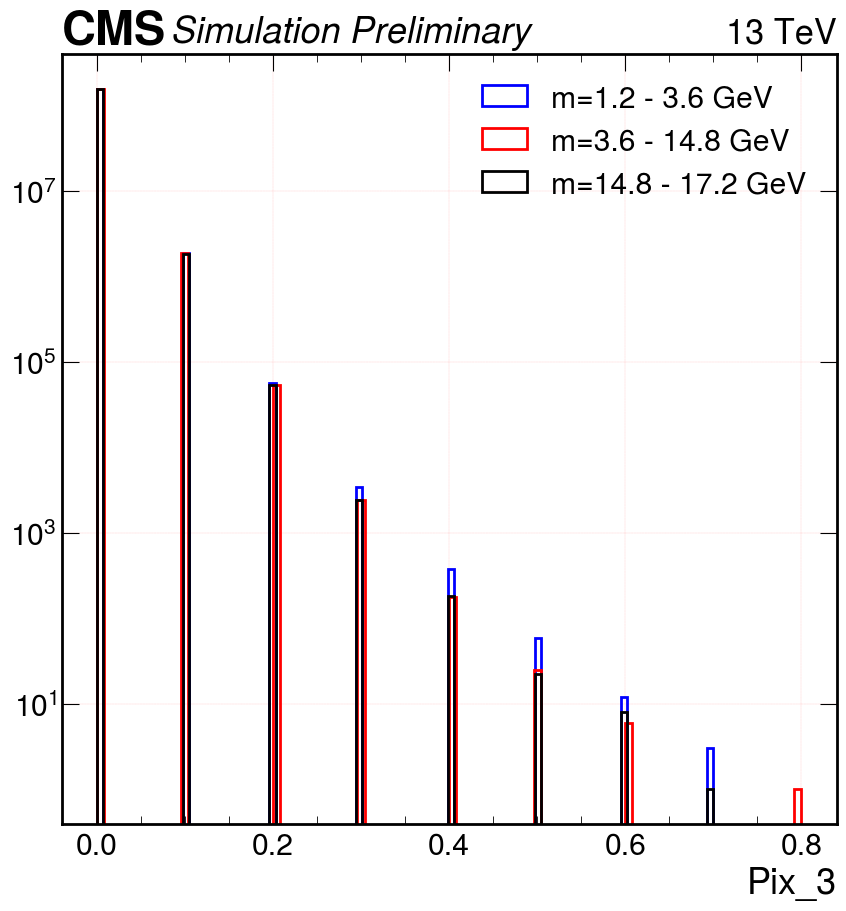

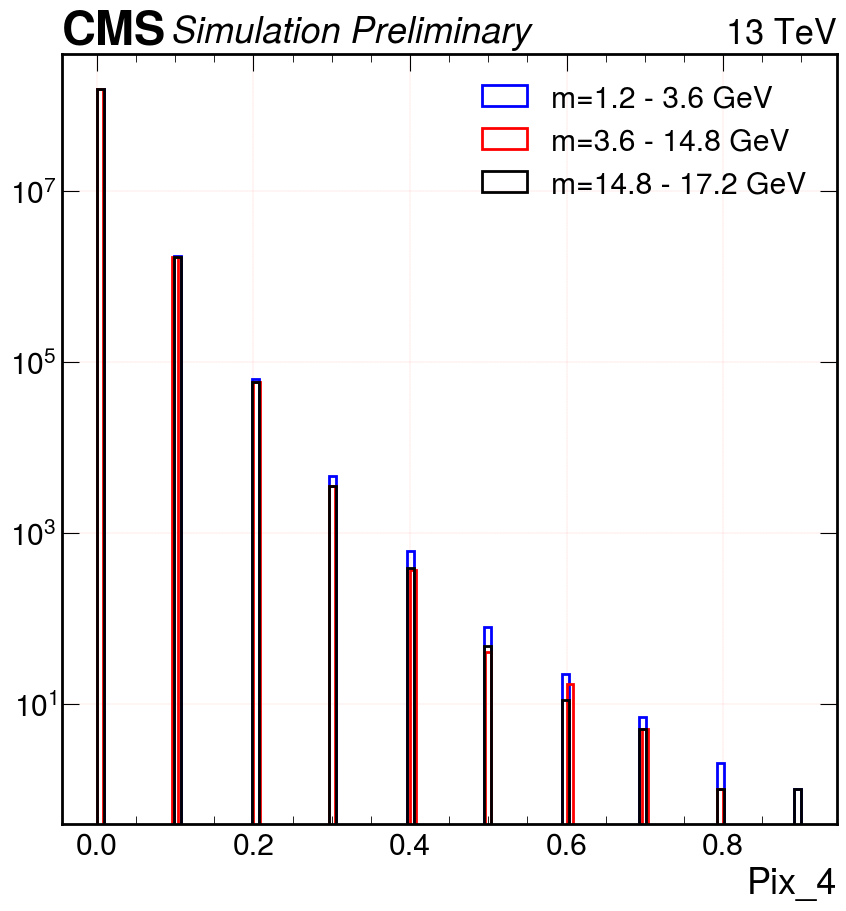

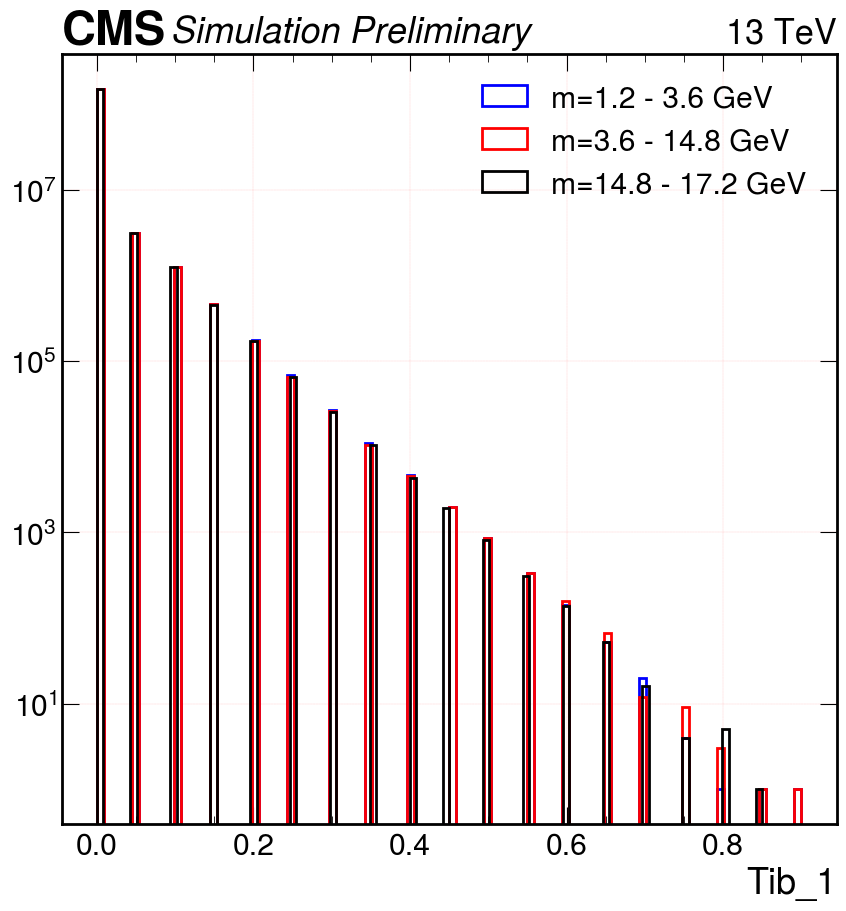

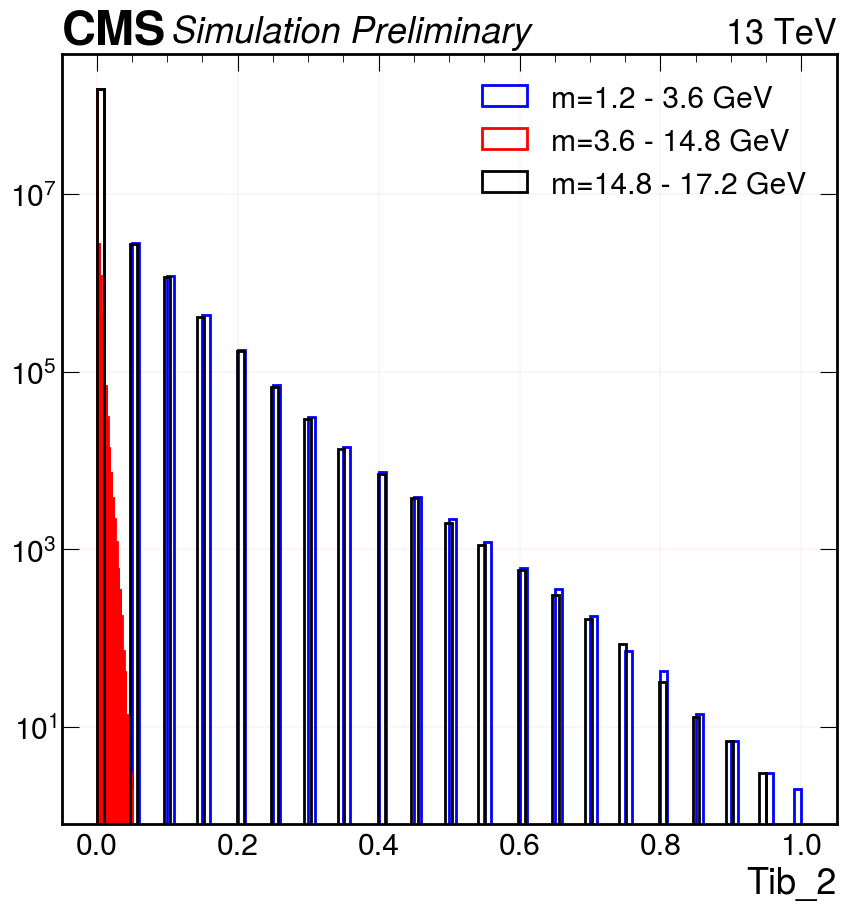

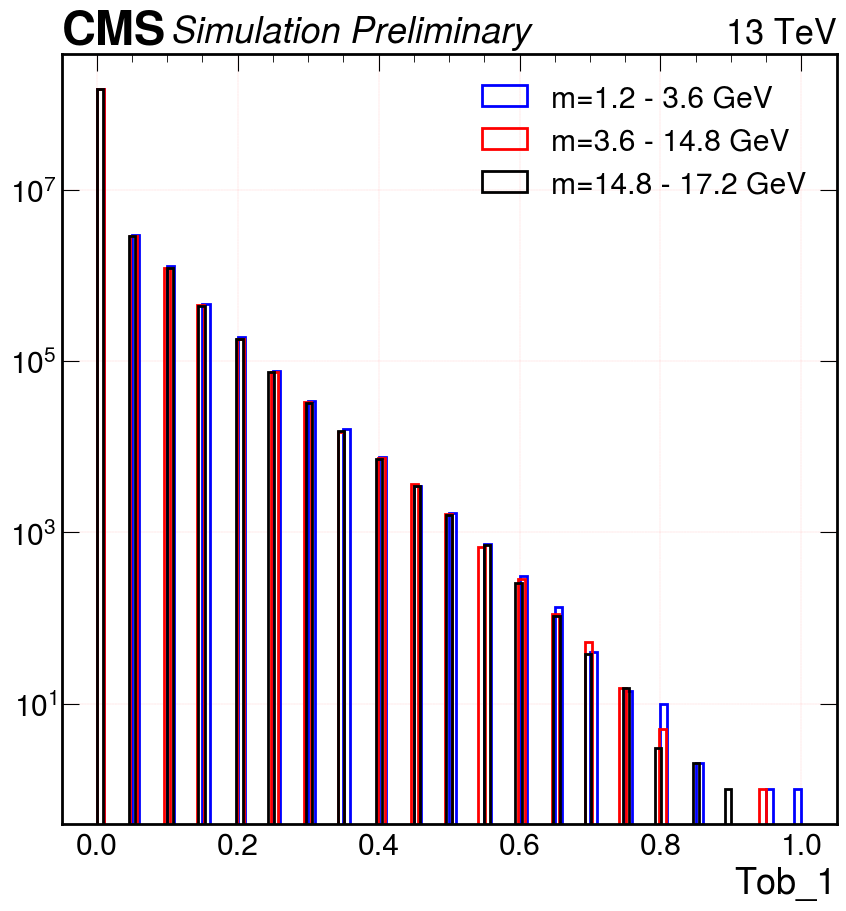

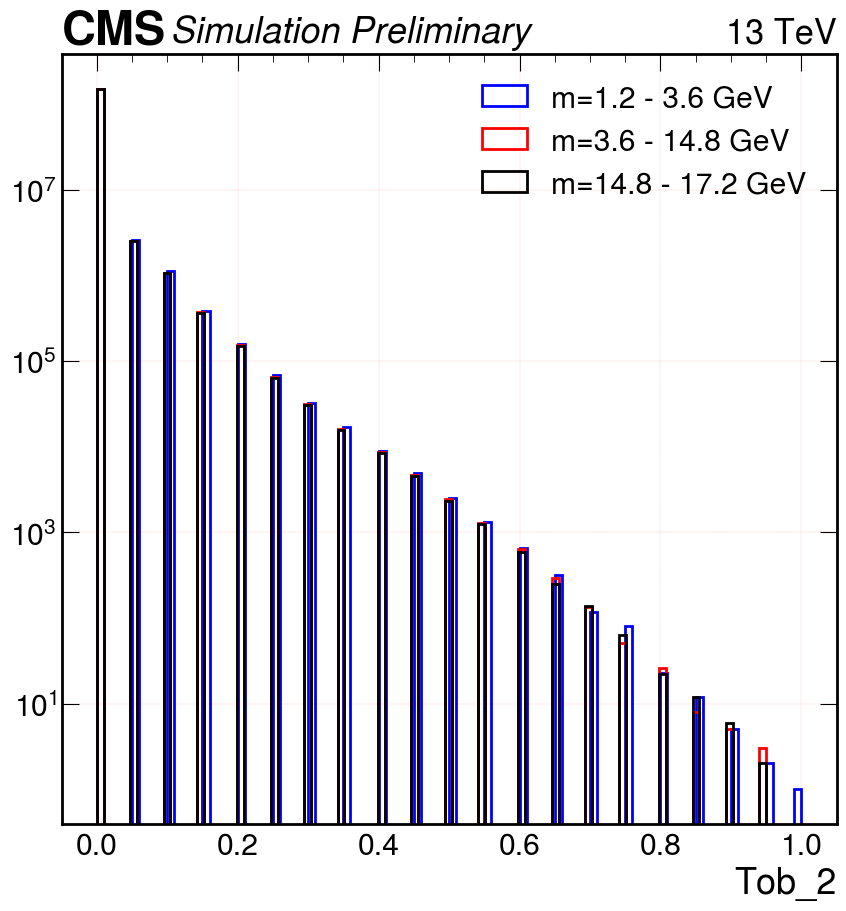

In [4]:
plot_scale_original('/pscratch/sd/b/bbbam/massreg_all_layers_data_to_check_scaling_m1p2To3p6.pkl', '/pscratch/sd/b/bbbam/massreg_all_layers_data_to_check_scaling_m3p6To14p8.pkl', '/pscratch/sd/b/bbbam/massreg_all_layers_data_to_check_scaling_m14To17p2.pkl')

In [2]:
# plot_scale_original('massreg_all_layers_data_to_check_scaling_m3p6To14p8.pkl')

In [3]:
# plot_scale_original('massreg_all_layers_data_to_check_scaling_m14To17p2.pkl')

### plot for scaled data

In [6]:
def plot_scale(file):
    with open(f'/pscratch/sd/b/bbbam/{file}', 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        data = u.load()
        
        
    hcal_scale  = 1
    ecal_scale  = 0.2
    pt_scale    = 0.02
    dz_scale    = 10
    d0_scale    = 10
    m0_scale    = 14    
    
    pt = pt_scale*data["Traks_pt"]
    dz = dz_scale*data["Tracks_dzsig"]
    d0 = d0_scale*data["Tracks_d0sig"]
    ECAL_energy = ecal_scale*data["ECAL_energy"]
    HBHE_energy = hcal_scale*data["HBHE_energy"]
    
    pt[pt < 1.e-3] = 0
    dz[dz < -20] = 0
    dz[dz > 20] = 0
    d0[d0 < -10] = 0
    d0[d0 > 10] = 0
    ECAL_energy[ECAL_energy < 1.e-3] = 0
    HBHE_energy[HBHE_energy < 1.e-3] = 0
    
    Pix_1 = data["Pix_1"]
    Pix_2 = data["Pix_2"]
    Pix_3 = data["Pix_3"]
    Pix_4 = data["Pix_4"]
    Tib_1 = data["Tib_1"]
    Tib_2 = data["Tib_2"]
    Tob_1 = data["Tob_1"]
    Tob_2 = data["Tob_2"]


    fig, ax = plt.subplots()
    plt.hist(pt, histtype='step',log=True,bins=10000, label='Tracks_pt', linestyle='-', color='blue', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('Tracks_pt')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(dz, histtype='step',log=True,bins=10000, label='Tracks_dzsig', linestyle='-', color='blue', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('Tracks_dzsig')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(d0, histtype='step',log=True,bins=10000, label='Tracks_d0sig', linestyle='-', color='blue', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('Tracks_d0sig')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(ECAL_energy, histtype='step',log=True,bins=10000, label='ECAL_energy', linestyle='-', color='blue', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('ECAL_energy')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(HBHE_energy, histtype='step',log=True,bins=10000, label='HBHE_energy', linestyle='-', color='blue', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('HBHE_energy')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(Pix_1, histtype='step',log=True,bins=10000, label='Pix_1', linestyle='-', color='blue', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('Pix_1')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(Pix_2, histtype='step',log=True,bins=10000, label='Pix_2', linestyle='-', color='blue', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('Pix_2')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(Pix_3, histtype='step',log=True,bins=10000, label='Pix_3', linestyle='-', color='blue', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('Pix_3')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(Pix_4, histtype='step',log=True,bins=10000, label='Pix_4', linestyle='-', color='blue', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('Pix_4')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(Tib_1, histtype='step',log=True,bins=10000, label='Tib_1', linestyle='-', color='blue', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('Tib_1')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(Tib_2, histtype='step',log=True,bins=10000, label='Tib_2', linestyle='-', color='blue', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('Tib_2')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(Tob_1, histtype='step',log=True,bins=10000, label='Tob_1', linestyle='-', color='blue', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('Tob_1')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(Tob_2, histtype='step',log=True,bins=10000, label='Tob_2', linestyle='-', color='blue', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('Tob_2')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()
    gc.collect()


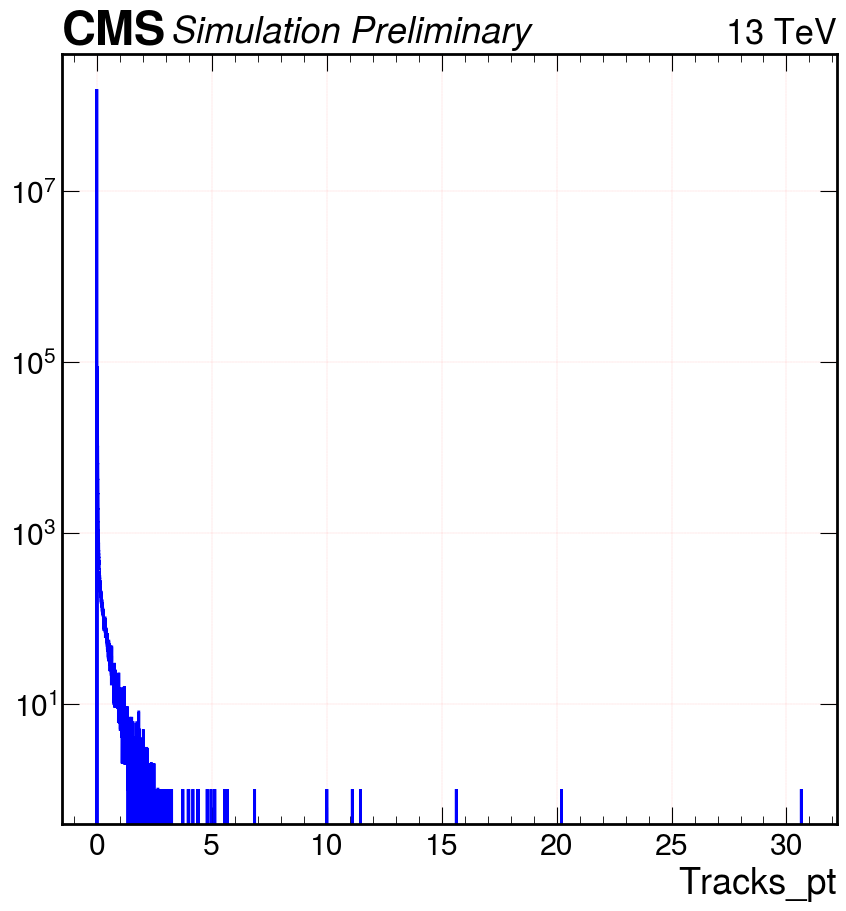

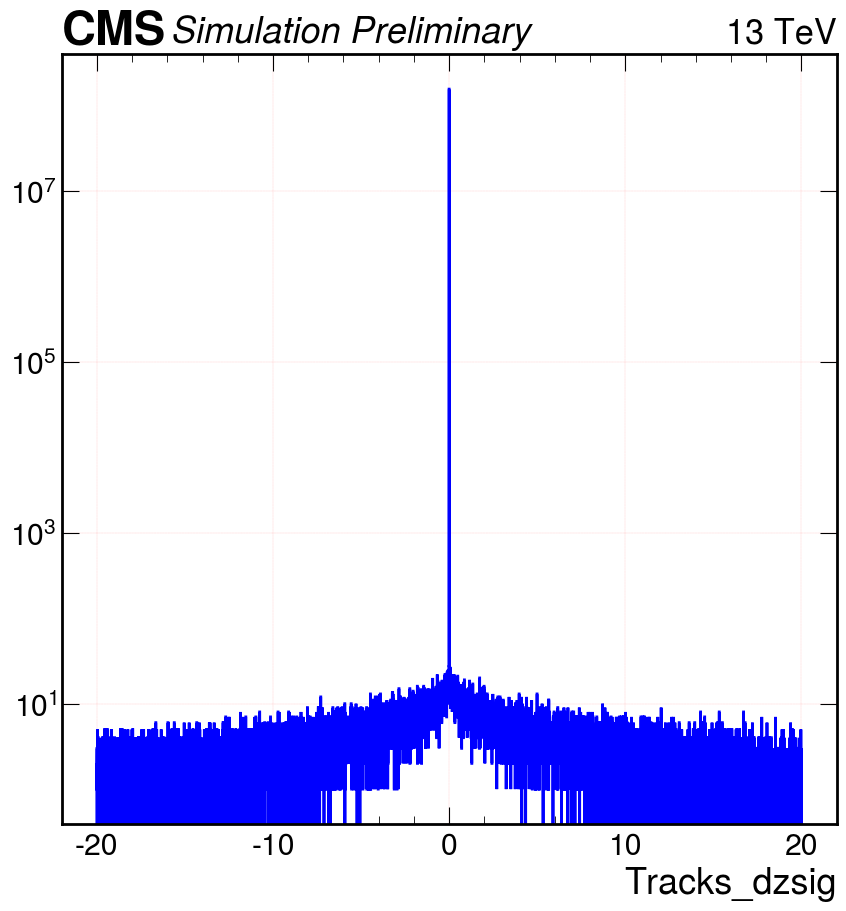

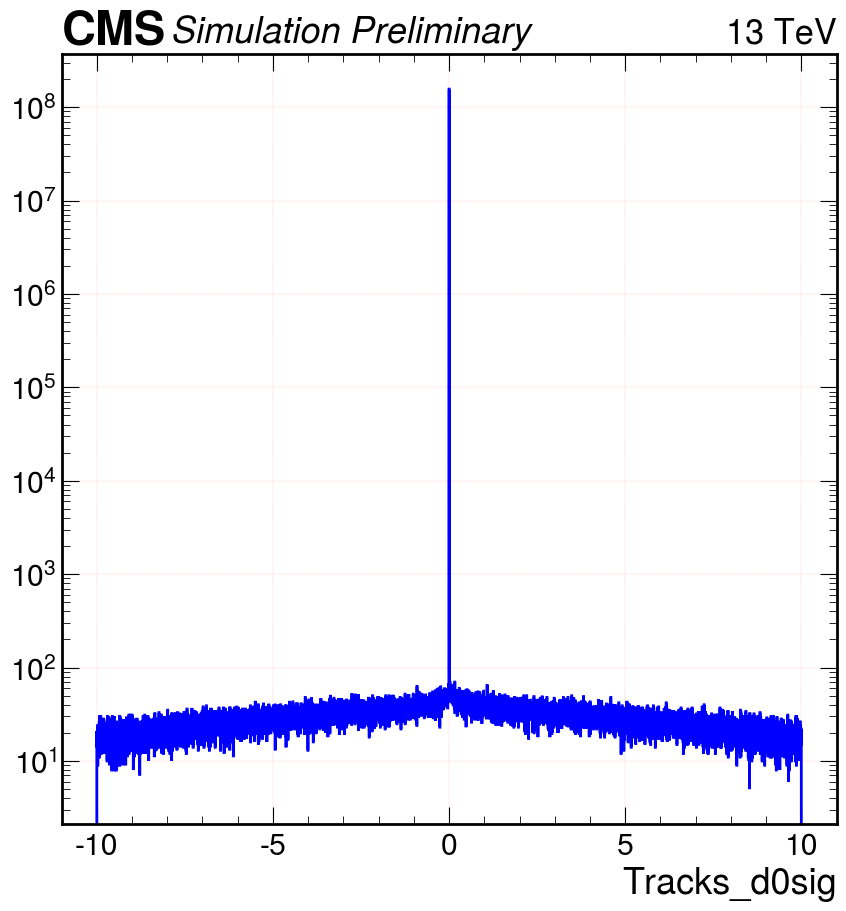

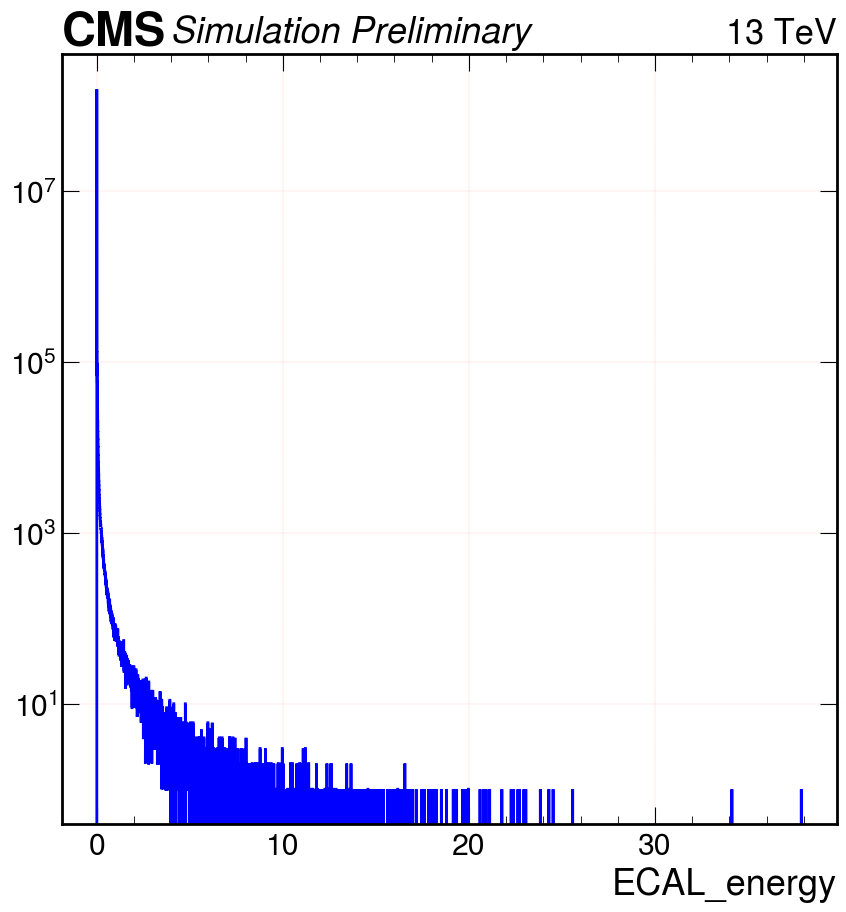

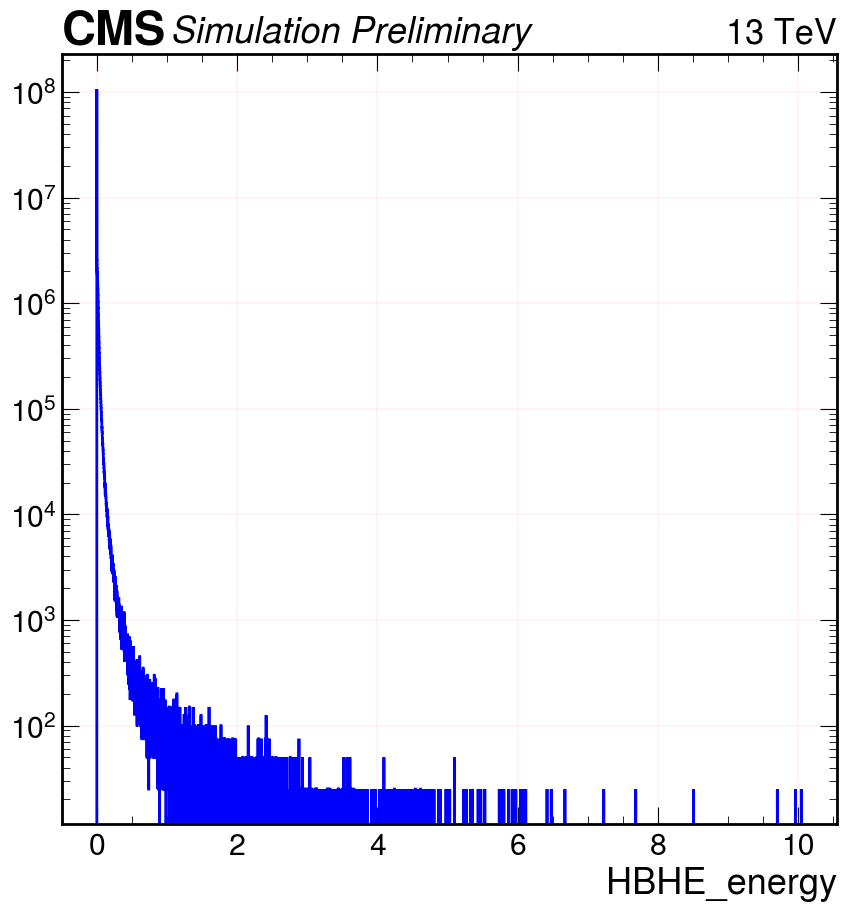

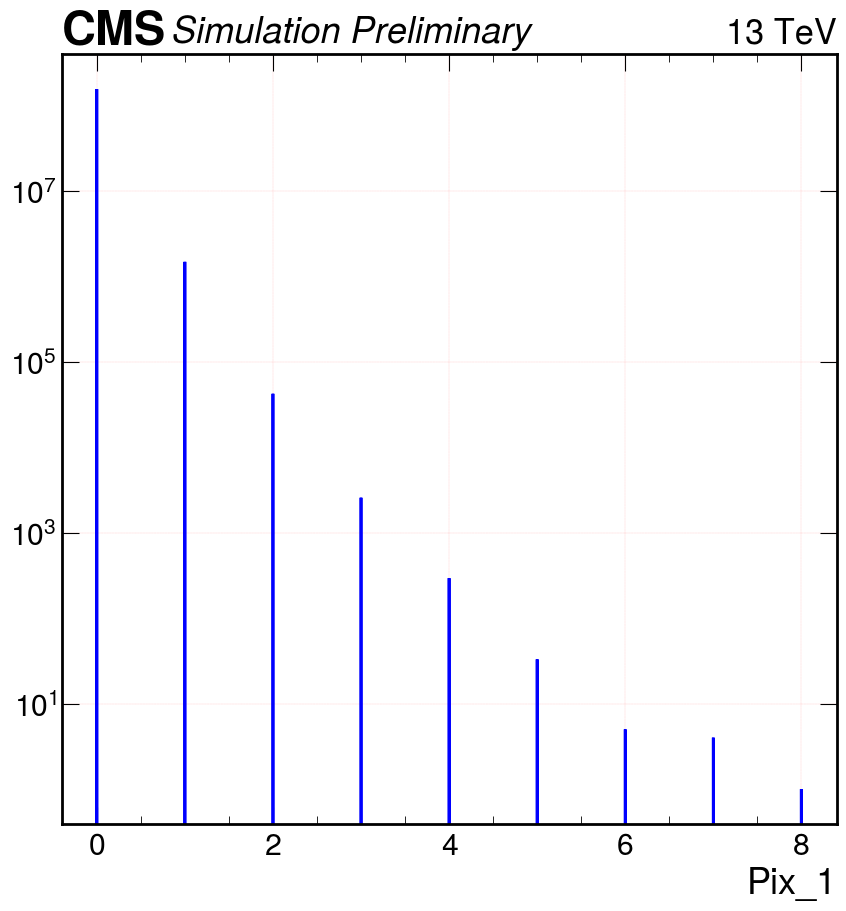

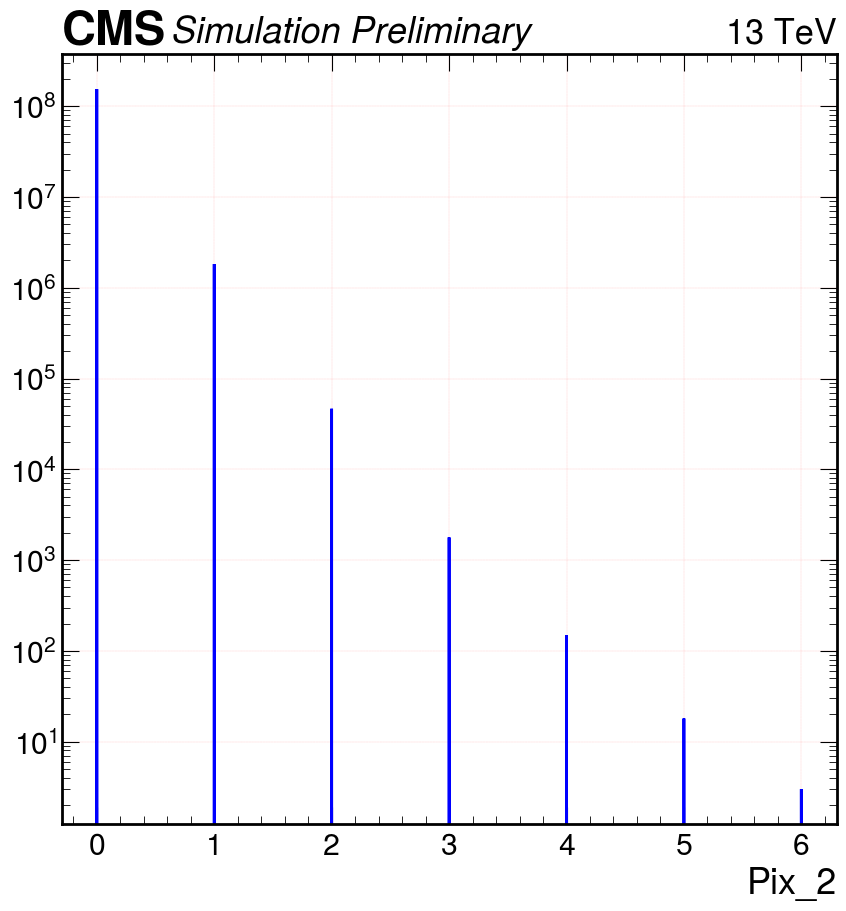

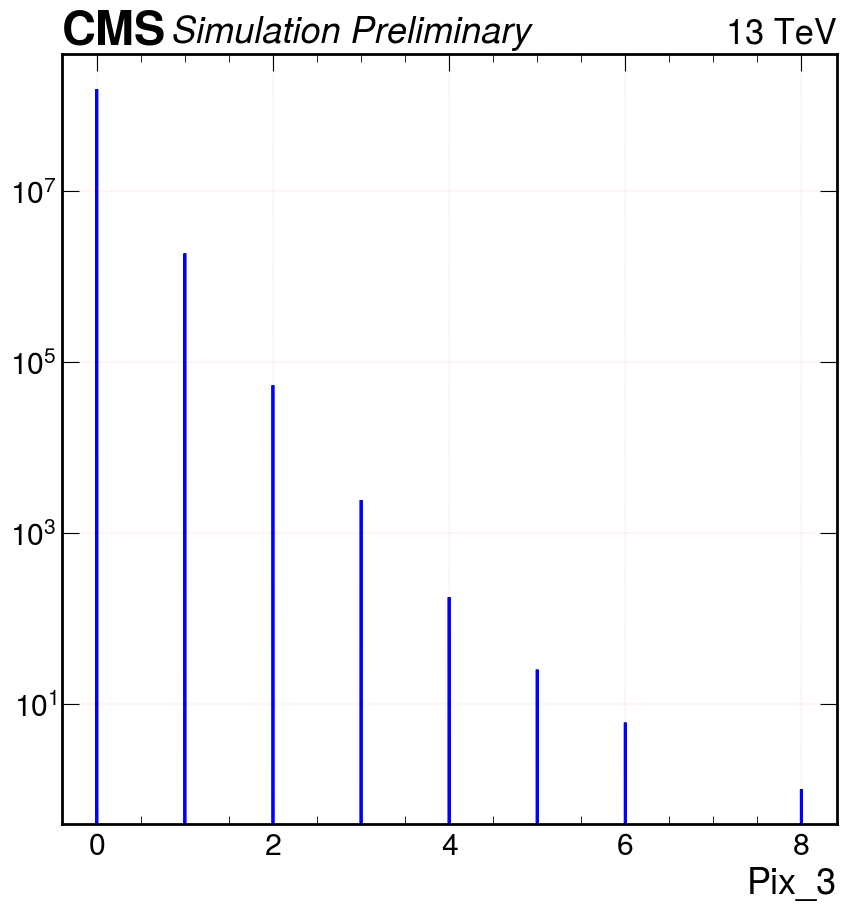

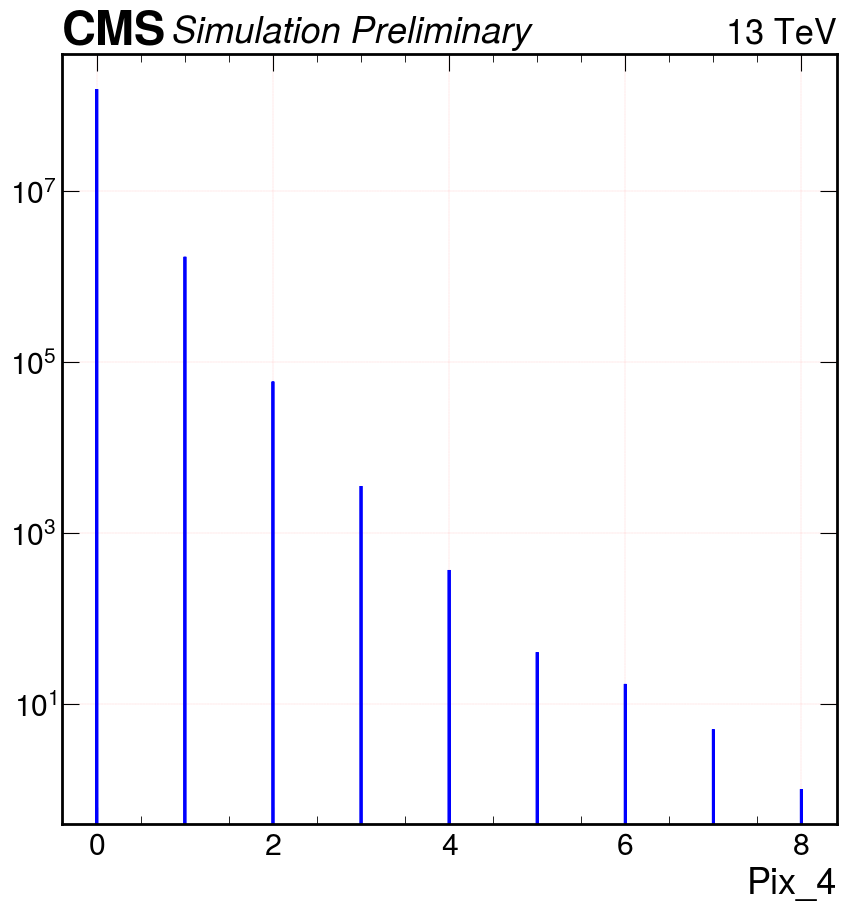

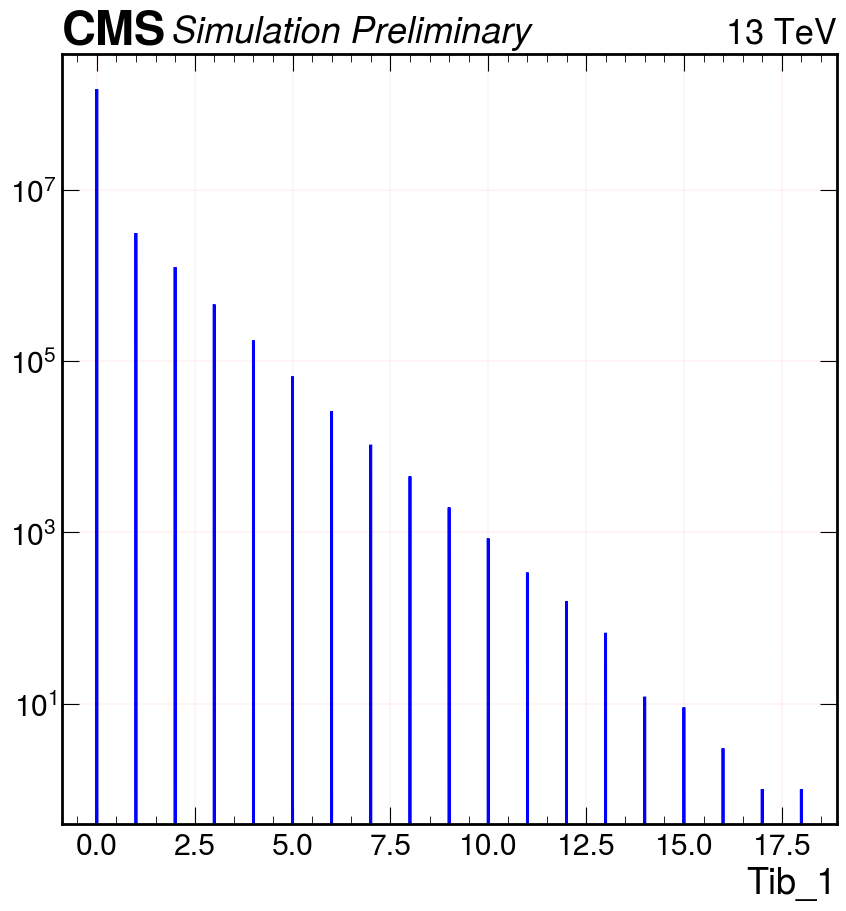

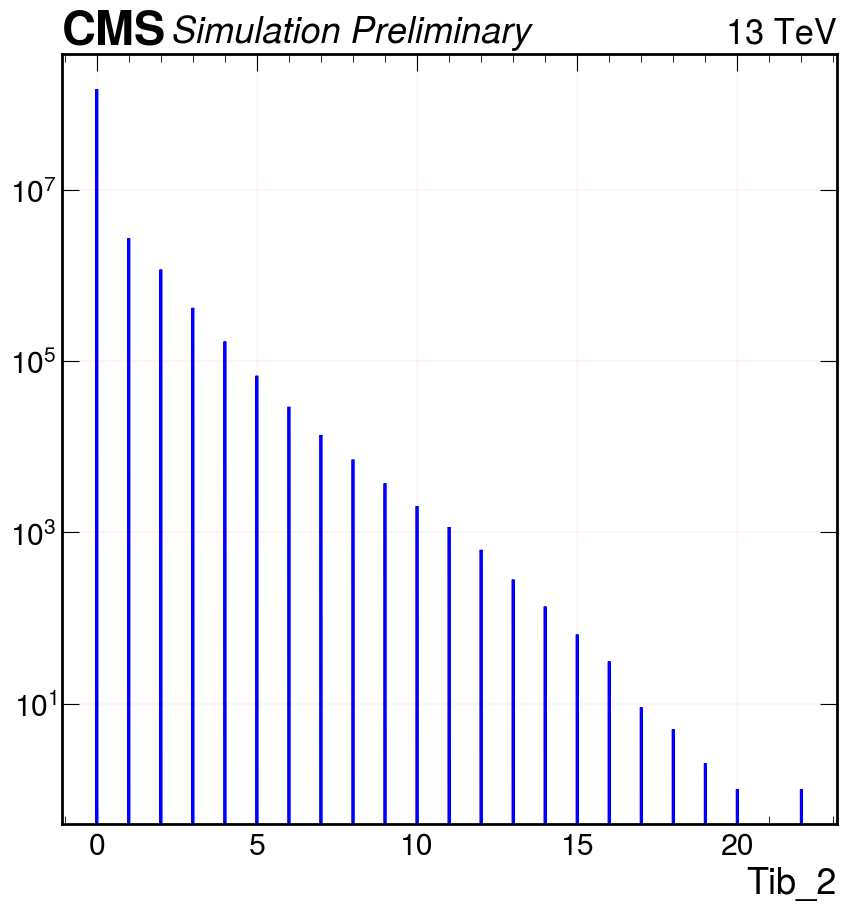

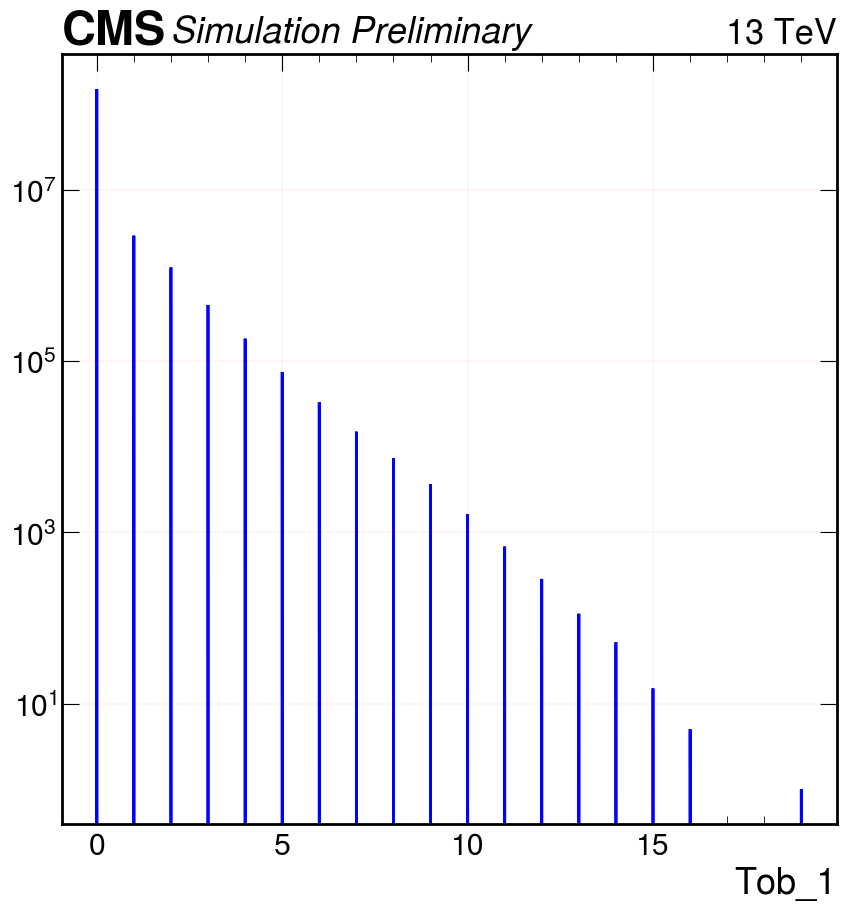

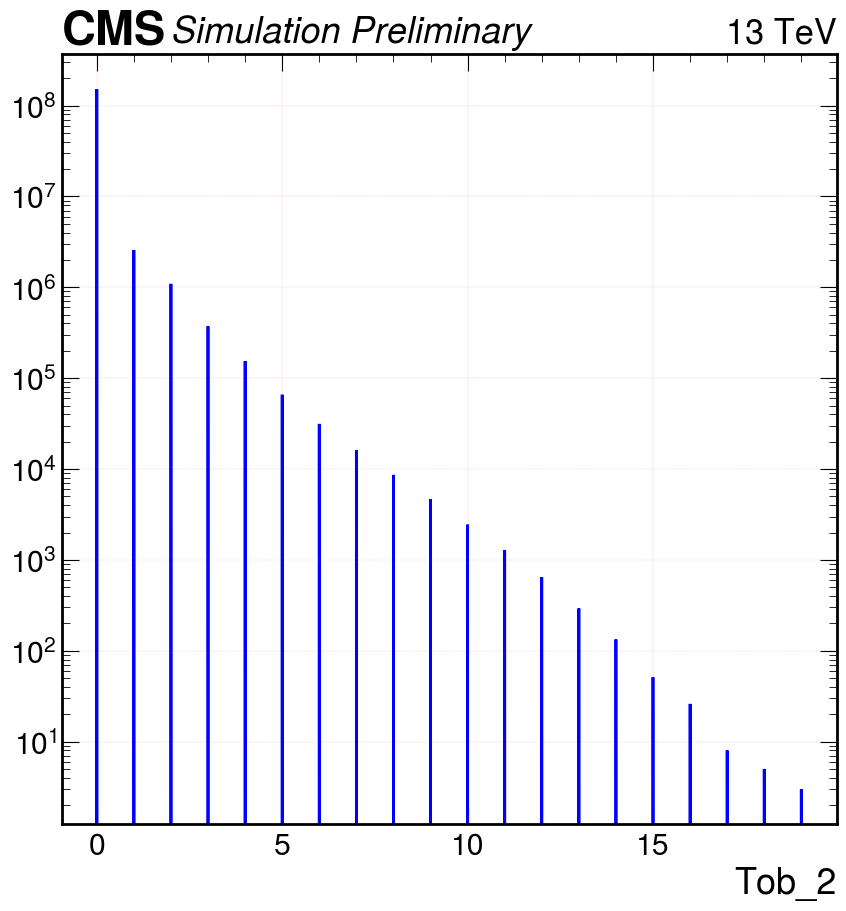

In [7]:
plot_scale('massreg_all_layers_data_to_check_scaling_m3p6To14p8.pkl')

In [15]:
with open(f'/pscratch/sd/b/bbbam/massreg_all_layers_data_to_check_scaling_m1p2To3p6.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    data = u.load()


hcal_scale  = 1
ecal_scale  = 0.2
pt_scale    = 0.02
dz_scale    = 10
m0_scale    = 14    

pt = data["Traks_pt"]

In [17]:
pt1 = pt*0.02

In [18]:
pt1[pt1 < 1.e-3]=0

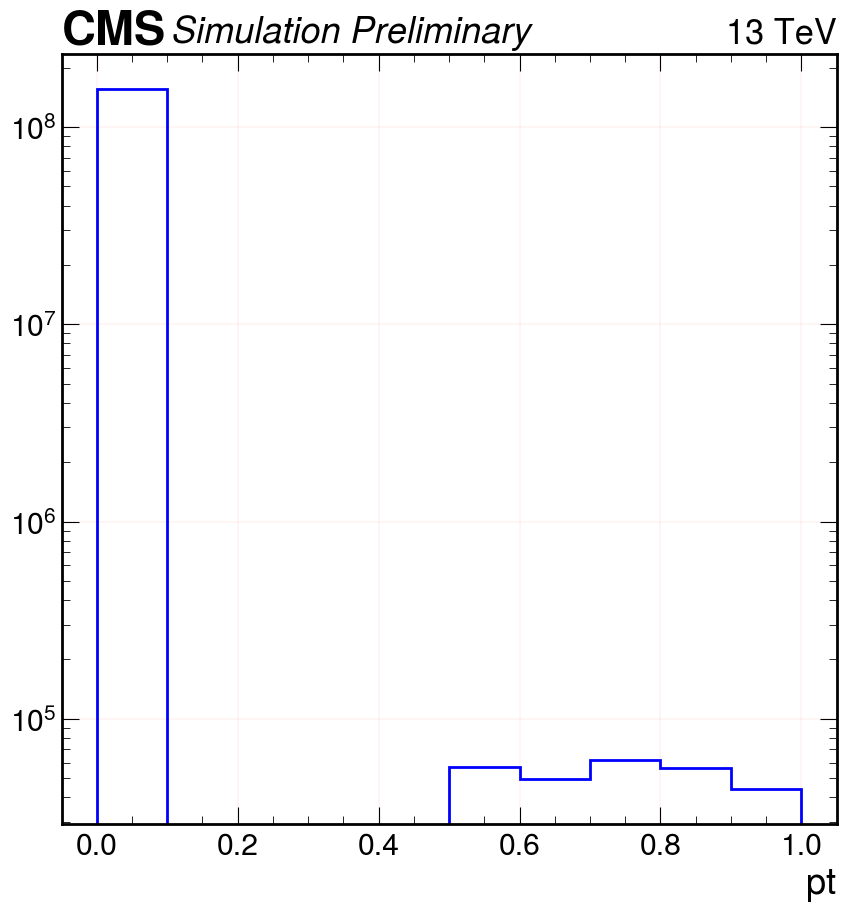

In [19]:
fig, ax = plt.subplots()
plt.hist(pt, histtype='step',range=(0,1),log=True,bins=10, linestyle='-', color='blue', linewidth=2)
plt.grid(color='r', linestyle='--', linewidth=.1)
plt.xlabel('pt')
hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
# if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
plt.show()

In [44]:
## -------Excute this line only save certian data from parquet to pkl 
# class ParquetDataset(Dataset):
#     def __init__(self, filename, label):
#         self.parquet = pq.ParquetFile(filename)
#         self.cols = ['X_jet.list.item.list.item.list.item']
#         self.label = label
#     def __getitem__(self, index):
#          data = self.parquet.read_row_group(index, columns=self.cols).to_pydict()
        
#          data['X_jet'] = np.float32(data['X_jet'][0])

#          return data['X_jet']
#     def __len__(self):
#         return self.parquet.num_row_groups
# train_decays = glob.glob('/pscratch/sd/b/bbbam/classification/valid/WJetsToLNu_valid.parquet')
# dset_train = ConcatDataset([ParquetDataset('%s'%d,i) for i,d in enumerate(train_decays)])
# n_eve = len(dset_train)
# print("Total events.  ", n_eve)

# idxs_train = np.random.permutation(1000)


# print('used events ', len(idxs_train))
# Tracks_pt, Tracks_dzsig, Tracks_d0sig,ECAL_energy, HBHE_energy, Pix_1, Pix_2, Pix_3, Pix_4,Tib_1, Tib_2, Tob_1, Tob_2 = [], [], [],[],[],[],[],[],[],[],[],[],[]
# for j,i in enumerate(idxs_train):
#     data = dset_train[i]
#     pt, dz, d0, Ecal, Hcal, Pix1, Pix2, Pix3, Pix4,Tib1, Tib2, Tob1,Tob2 = data[0].flatten(), data[1].flatten(), data[2].flatten(),data[3].flatten(),data[4].flatten(),data[5].flatten(),data[6].flatten(),data[7].flatten(),data[8].flatten(),data[9].flatten(),data[10].flatten(),data[11].flatten(),data[12].flatten()
#     Tracks_pt.append(pt)
#     Tracks_dzsig.append(dz)
#     Tracks_d0sig.append(d0)
#     ECAL_energy.append(Ecal)
#     HBHE_energy.append(Hcal)
#     Pix_1.append(Pix1)
#     Pix_2.append(Pix2)
#     Pix_3.append(Pix3)
#     Pix_4.append(Pix4)
#     Tib_1.append(Tib1)
#     Tib_2.append(Tib2)
#     Tob_1.append(Tob1)
#     Tob_2.append(Tob2)
#     if j % 100 == 0:
#         print(f"processing event {j} with actual event {i}")

# output_dict = {}
# print("wriring to output file")
# output_dict["Traks_pt"] = np.concatenate(Tracks_pt, axis=0)
# output_dict["Tracks_dzsig"] = np.concatenate(Tracks_dzsig, axis=0)
# output_dict["Tracks_d0sig"] = np.concatenate(Tracks_d0sig, axis=0)
# output_dict["ECAL_energy"] = np.concatenate(ECAL_energy, axis=0)
# output_dict["HBHE_energy"] = np.concatenate( HBHE_energy, axis=0)
# output_dict["Pix_1"] = np.concatenate(Pix_1, axis=0)
# output_dict["Pix_2"] = np.concatenate(Pix_2, axis=0)
# output_dict["Pix_3"] = np.concatenate(Pix_3, axis=0)
# output_dict["Pix_4"] = np.concatenate(Pix_4, axis=0)
# output_dict["Tib_1"] = np.concatenate(Tib_1, axis=0)
# output_dict["Tib_2"] = np.concatenate(Tib_2, axis=0)
# output_dict["Tob_1"] = np.concatenate(Tob_1, axis=0)
# output_dict["Tob_2"] = np.concatenate(Tob_2, axis=0)

# with open("%s/DYT_.pkl" % os.environ['SCRATCH'], "wb") as outfile:
#     pickle.dump(output_dict, outfile, protocol=2)
# print("DONE")
# gc.collect()

Total events.   85000
used events  1000
processing event 0 with actual event 213
processing event 100 with actual event 271
processing event 200 with actual event 876
processing event 300 with actual event 479
processing event 400 with actual event 816
processing event 500 with actual event 871
processing event 600 with actual event 797
processing event 700 with actual event 168
processing event 800 with actual event 823
processing event 900 with actual event 94
wriring to output file
DONE


0

In [2]:
def plot_scale_new(file1, file2, file3):
    bins = 100
    with open(file1, 'rb') as f1:
        u1 = pickle._Unpickler(f1)
        u1.encoding = 'latin1'
        data1 = u1.load()
    
    pt1 = data1["Traks_pt"]
    dz1 = data1["Tracks_dzsig"]
    d01 = data1["Tracks_d0sig"]
    ECAL_energy1 = data1["ECAL_energy"]
    HBHE_energy1 = data1["HBHE_energy"]
    Pix_11 = data1["Pix_1"]
    Pix_21 = data1["Pix_2"]
    Pix_31 = data1["Pix_3"]
    Pix_41 = data1["Pix_4"]
    Tib_11 = data1["Tib_1"]
    Tib_21 = data1["Tib_2"]
    Tob_11 = data1["Tob_1"]
    Tob_21 = data1["Tob_2"]

    with open(file2, 'rb') as f2:
        u2 = pickle._Unpickler(f2)
        u2.encoding = 'latin1'
        data2 = u2.load()
    
    pt2 = data2["Traks_pt"]
    dz2 = data2["Tracks_dzsig"]
    d02 = data2["Tracks_d0sig"]
    ECAL_energy2 = data2["ECAL_energy"]
    HBHE_energy2 = data2["HBHE_energy"]
    Pix_12 = data2["Pix_1"]
    Pix_22 = data2["Pix_2"]
    Pix_32 = data2["Pix_3"]
    Pix_42 = data2["Pix_4"]
    Tib_12 = data2["Tib_1"]
    Tib_22 = data2["Tib_2"]
    Tob_12 = data2["Tob_1"]
    Tob_22 = data2["Tob_2"]
    
    
    with open(file3, 'rb') as f3:
        u3 = pickle._Unpickler(f3)
        u3.encoding = 'latin1'
        data3 = u3.load()
    
    pt3 = data3["Traks_pt"]
    dz3 = data3["Tracks_dzsig"]
    d03 = data3["Tracks_d0sig"]
    ECAL_energy3 = data3["ECAL_energy"]
    HBHE_energy3 = data3["HBHE_energy"]
    Pix_13 = data3["Pix_1"]
    Pix_23 = data3["Pix_2"]
    Pix_33 = data3["Pix_3"]
    Pix_43 = data3["Pix_4"]
    Tib_13 = data3["Tib_1"]
    Tib_23 = data3["Tib_2"]
    Tob_13 = data3["Tob_1"]
    Tob_23 = data3["Tob_2"]
    
    
    
    pt_scale    = 0.2    
    ecal_scale  = 0.2   
    hcal_scale  = 1
    dz_scale    = 0.1
    d0_scale    = 0.05
    pix_scale = 0.1
    tracker_scale = 0.05
    
    pt1[pt1 > 5] = 0
    ECAL_energy1[ECAL_energy1 > 5] = 0
    HBHE_energy1[HBHE_energy1 > 1] =0
    dz1[abs(dz1) > 10] = 0
    d01[abs(d01) > 20] = 0
    Pix_11[Pix_11>10] =0
    Pix_21[Pix_21>10] =0
    Pix_31[Pix_31>10] =0
    Pix_41[Pix_41>10] =0
    Tib_11[Tib_11 > 20] =0
    Tib_21[Tib_21 > 20] =0 
    Tob_11[Tob_11 > 20] =0
    Tob_21[Tob_21 > 20] =0 


    pt1=pt_scale*pt1
    dz1 = dz_scale*dz1
    d01 = d0_scale*d01
    ECAL_energy1 = ecal_scale*ECAL_energy1
    HBHE_energy1 = hcal_scale*HBHE_energy1
    Pix_11 = pix_scale*Pix_11
    Pix_21 = pix_scale*Pix_21
    Pix_31 = pix_scale*Pix_31
    Pix_41 = pix_scale*Pix_41
    Tib_11 = tracker_scale*Tib_11
    Tib_21 = tracker_scale*Tib_21
    Tob_11 = tracker_scale*Tob_11
    Tob_21 = tracker_scale*Tob_21
    
    pt2[pt2 > 5] = 0
    ECAL_energy2[ECAL_energy2 > 5] = 0
    HBHE_energy2[HBHE_energy2 > 1] =0
    dz2[abs(dz2) > 10] = 0
    d02[abs(d02) > 20] = 0
    Pix_12[Pix_12>10] =0
    Pix_22[Pix_22>10] =0
    Pix_32[Pix_32>10] =0
    Pix_42[Pix_42>10] =0
    Tib_12[Tib_12 > 20] =0
    Tib_22[Tib_22 > 20] =0 
    Tob_12[Tob_12 > 20] =0
    Tob_22[Tob_22 > 20] =0 


    pt2=pt_scale*pt2
    dz2 = dz_scale*dz2
    d02 = d0_scale*d02
    ECAL_energy2 = ecal_scale*ECAL_energy2
    HBHE_energy2 = hcal_scale*HBHE_energy2
    Pix_12 = pix_scale*Pix_12
    Pix_22 = pix_scale*Pix_22
    Pix_32 = pix_scale*Pix_32
    Pix_42 = pix_scale*Pix_42
    Tib_12 = tracker_scale*Tib_12
    Tib_22 = tracker_scale*Tib_21
    Tob_12 = tracker_scale*Tob_12
    Tob_22 = tracker_scale*Tob_22
    
    pt3[pt3 > 5] = 0
    ECAL_energy3[ECAL_energy3 > 5] = 0
    HBHE_energy3[HBHE_energy3 > 1] =0
    dz3[abs(dz3) > 10] = 0
    d03[abs(d03) > 20] = 0
    Pix_13[Pix_13>10] =0
    Pix_23[Pix_23>10] =0
    Pix_33[Pix_33>10] =0
    Pix_43[Pix_43>10] =0
    Tib_13[Tib_13 > 20] =0
    Tib_23[Tib_23 > 20] =0 
    Tob_13[Tob_13 > 20] =0
    Tob_23[Tob_23 > 20] =0 


    pt3=pt_scale*pt3
    dz3 = dz_scale*dz3
    d03 = d0_scale*d03
    ECAL_energy3 = ecal_scale*ECAL_energy3
    HBHE_energy3 = hcal_scale*HBHE_energy3
    Pix_13 = pix_scale*Pix_13
    Pix_23 = pix_scale*Pix_23
    Pix_33 = pix_scale*Pix_33
    Pix_43 = pix_scale*Pix_43
    Tib_13 = tracker_scale*Tib_13
    Tib_23 = tracker_scale*Tib_23
    Tob_13 = tracker_scale*Tob_13
    Tob_23 = tracker_scale*Tob_23
    

    fig, ax = plt.subplots()
    plt.hist(pt1, histtype='step',log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
    plt.hist(pt2, histtype='step',log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
    plt.hist(pt3, histtype='step',log=True,bins=bins, label='m=4.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('Tracks_pt')
    plt.legend(loc='best')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(dz1, histtype='step',log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
    plt.hist(dz2, histtype='step',log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
    plt.hist(dz3, histtype='step',log=True,bins=bins, label='m=14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('Tracks_dzsig')
    plt.legend(loc='best')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(d01, histtype='step', log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
    plt.hist(d02, histtype='step', log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
    plt.hist(d03, histtype='step', log=True,bins=bins, label='m=14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('Tracks_d0sig')
    plt.legend(loc='best')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(ECAL_energy1, histtype='step', log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
    plt.hist(ECAL_energy2, histtype='step', log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
    plt.hist(ECAL_energy3, histtype='step', log=True,bins=bins, label='m= 14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('ECAL_energy')
    plt.legend(loc='best')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(HBHE_energy1, histtype='step', log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
    plt.hist(HBHE_energy2, histtype='step', log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
    plt.hist(HBHE_energy3, histtype='step', log=True,bins=bins, label='m=14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('HBHE_energy')
    plt.legend(loc='best')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(Pix_11, histtype='step', log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
    plt.hist(Pix_12, histtype='step', log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
    plt.hist(Pix_13, histtype='step', log=True,bins=bins, label='m=14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('Pix_1')
    plt.legend(loc='best')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(Pix_21, histtype='step',log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
    plt.hist(Pix_22, histtype='step',log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
    plt.hist(Pix_23, histtype='step',log=True,bins=bins, label='m=14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('Pix_2')
    plt.legend(loc='best')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(Pix_31, histtype='step', log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
    plt.hist(Pix_32, histtype='step', log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
    plt.hist(Pix_33, histtype='step', log=True,bins=bins, label='m=14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('Pix_3')
    plt.legend(loc='best')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(Pix_41, histtype='step', log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
    plt.hist(Pix_42, histtype='step', log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
    plt.hist(Pix_43, histtype='step', log=True,bins=bins, label='m=14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('Pix_4')
    plt.legend(loc='best')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(Tib_11, histtype='step', log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
    plt.hist(Tib_12, histtype='step', log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
    plt.hist(Tib_13, histtype='step', log=True,bins=bins, label='m=14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('Tib_1')
    plt.legend(loc='best')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(Tib_21, histtype='step', log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
    plt.hist(Tib_22, histtype='step', log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
    plt.hist(Tib_23, histtype='step', log=True,bins=bins, label='m=14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('Tib_2')
    plt.legend(loc='best')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(Tob_11, histtype='step', log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
    plt.hist(Tob_12, histtype='step', log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
    plt.hist(Tob_13, histtype='step', log=True,bins=bins, label='m=14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('Tob_1')
    plt.legend(loc='best')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()

    fig, ax = plt.subplots()
    plt.hist(Tob_21, histtype='step', log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
    plt.hist(Tob_22, histtype='step', log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
    plt.hist(Tob_23, histtype='step', log=True,bins=bins, label='m=14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
    plt.grid(color='r', linestyle='--', linewidth=.1)
    plt.xlabel('Tob_2')
    plt.legend(loc='best')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
    plt.show()
    gc.collect()

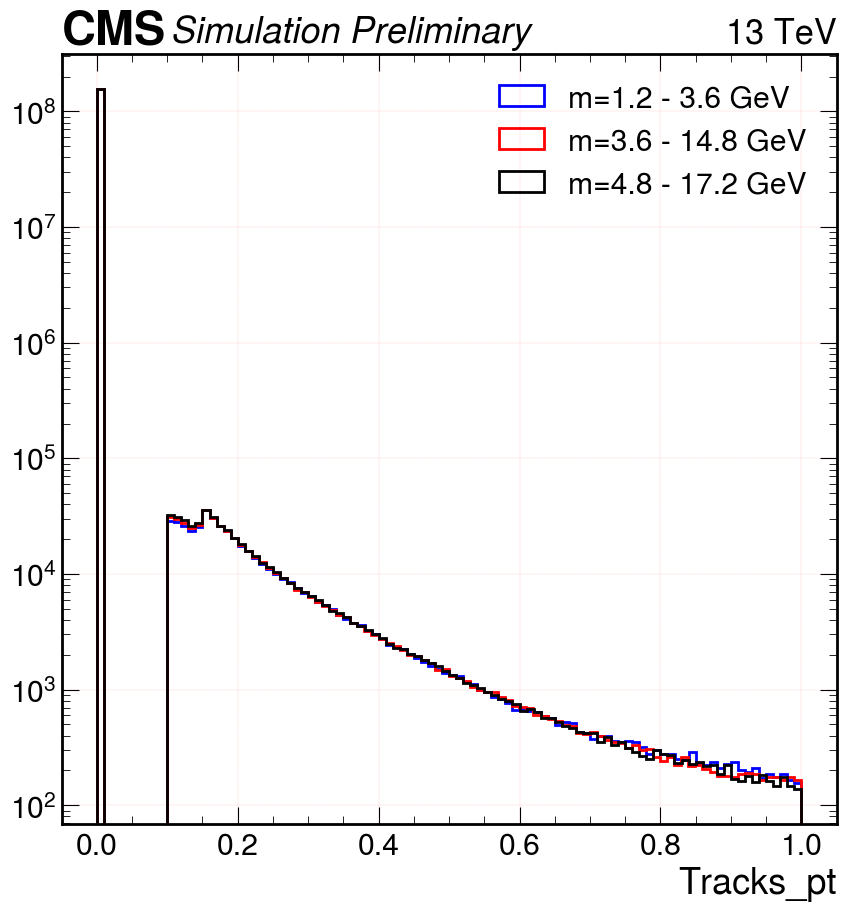

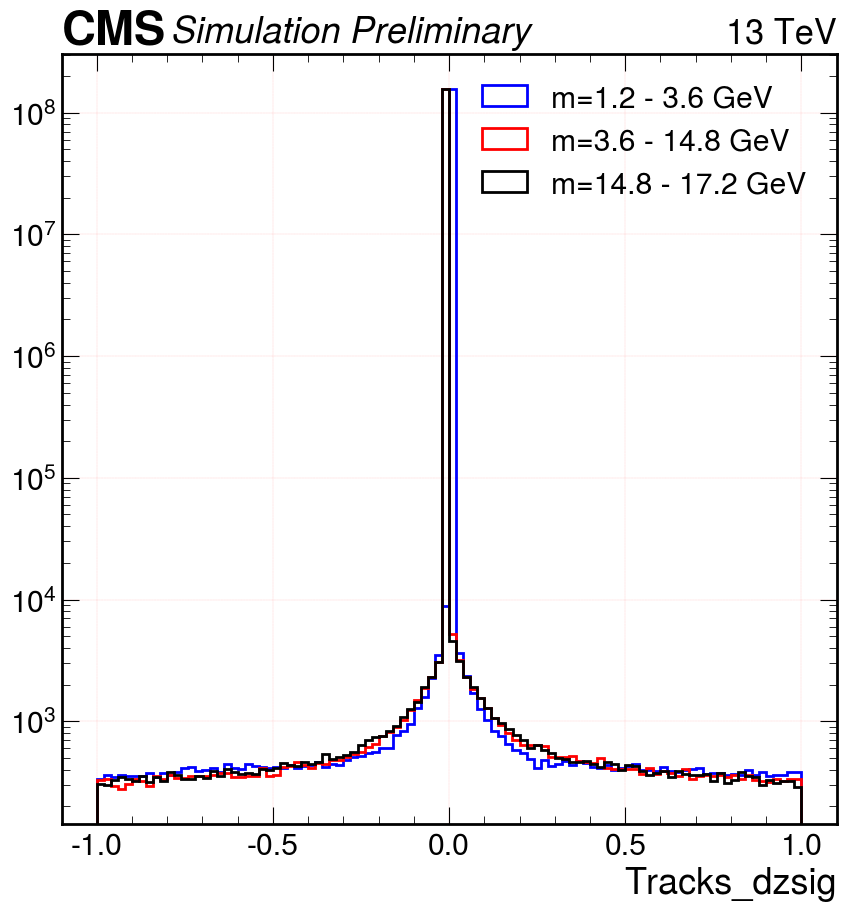

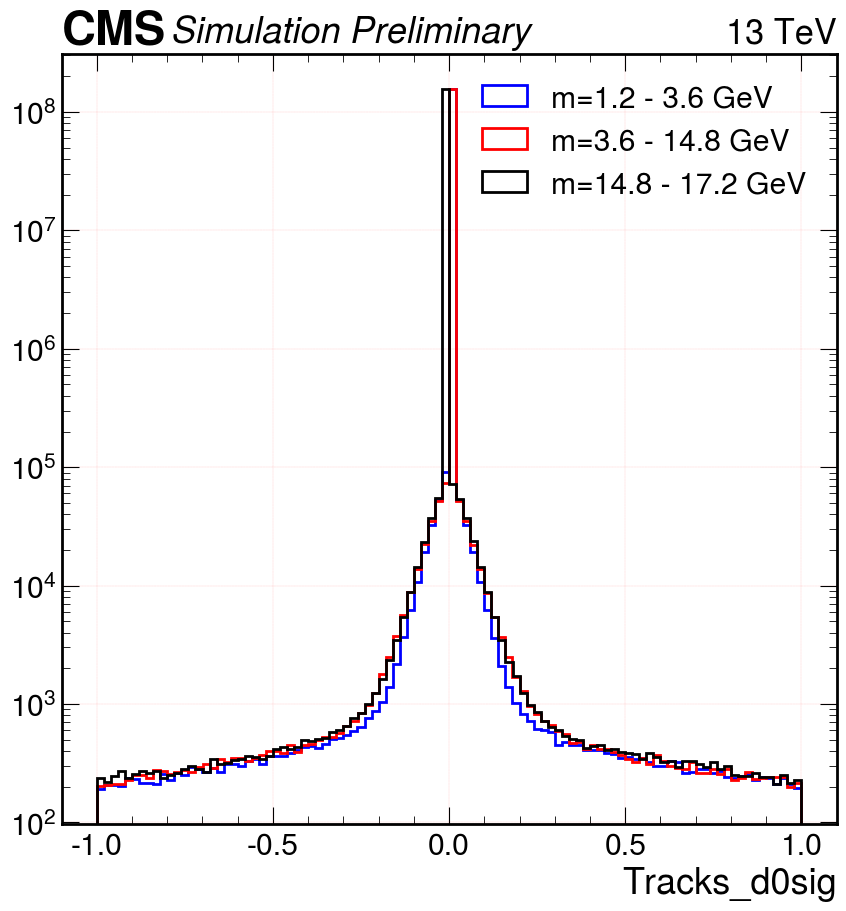

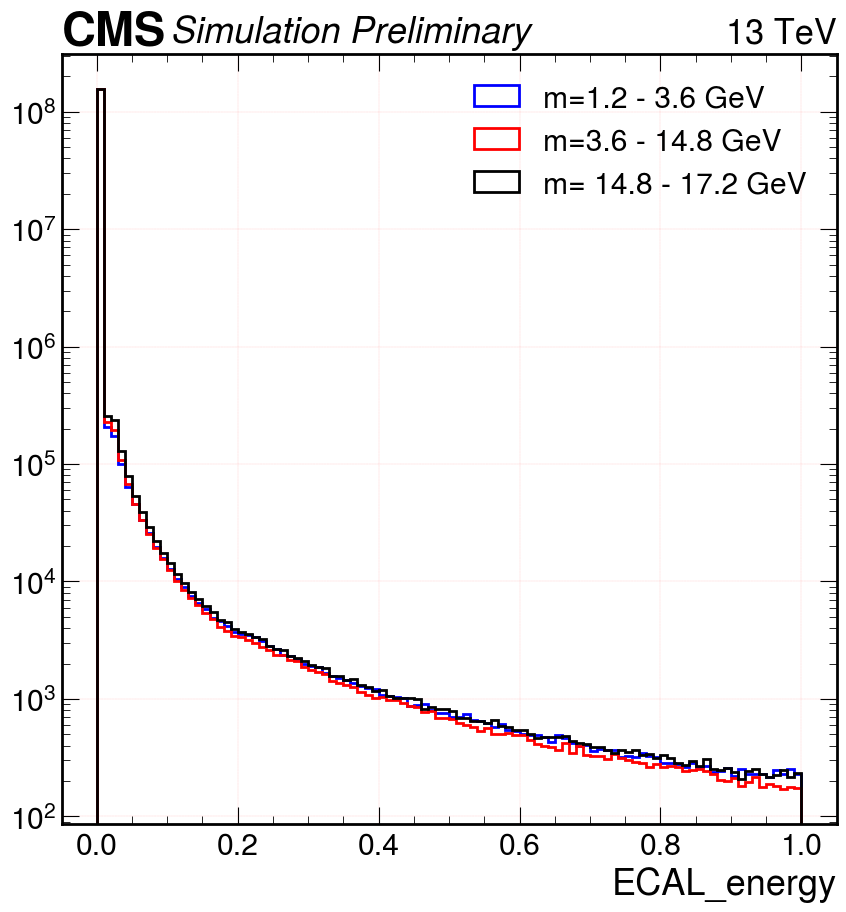

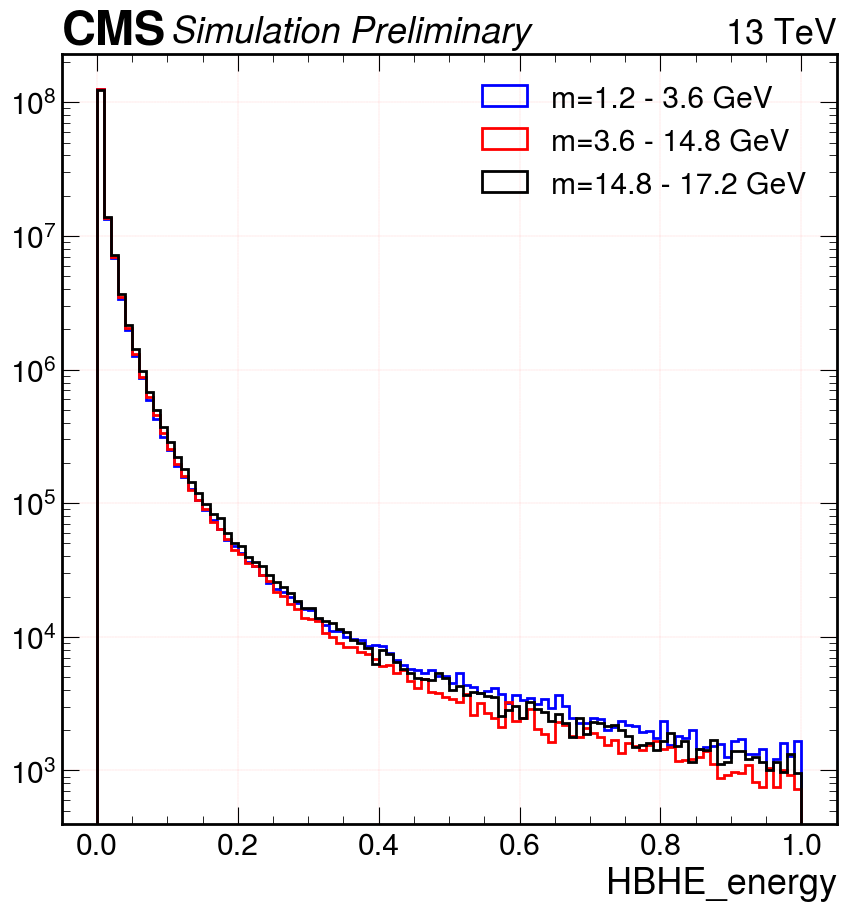

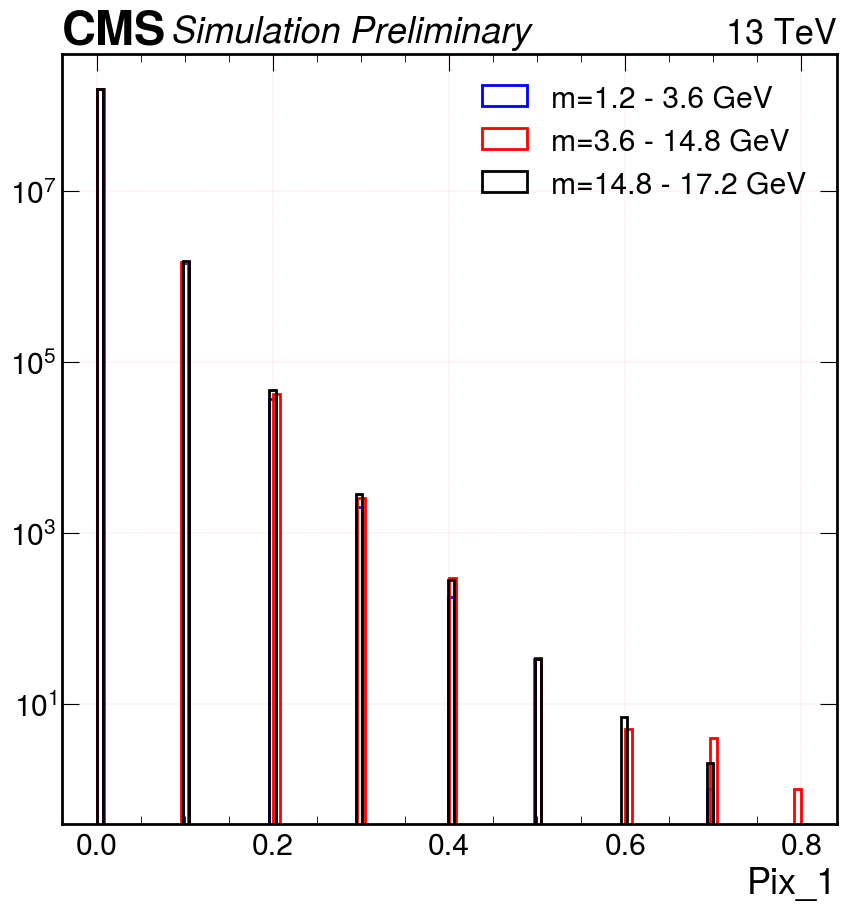

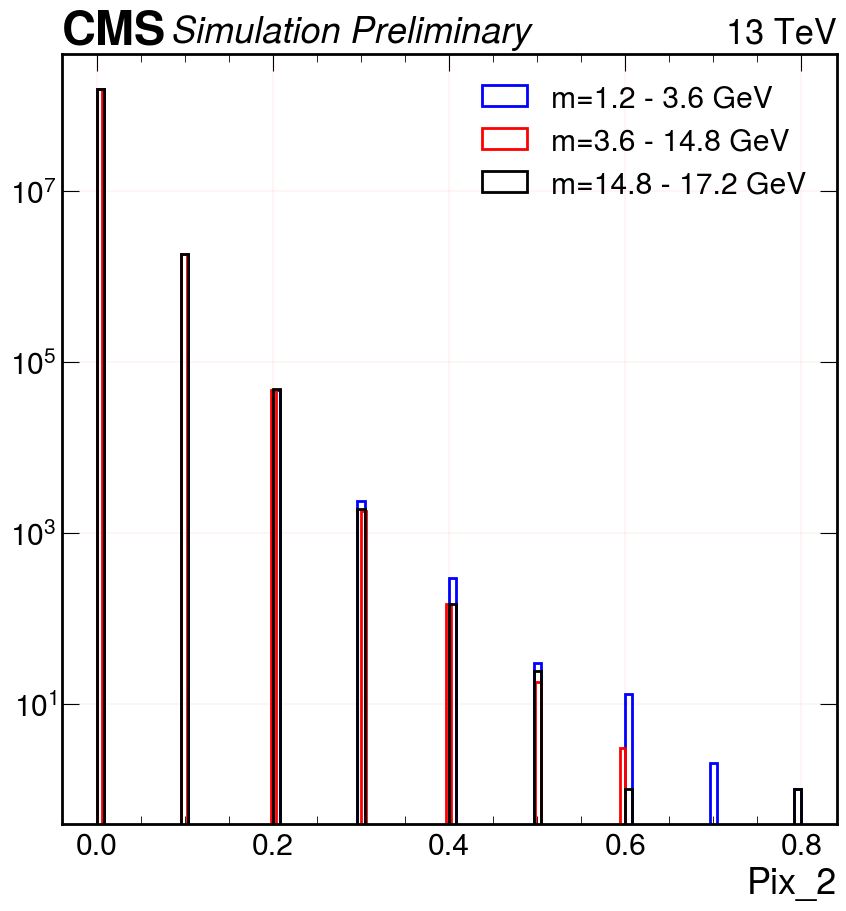

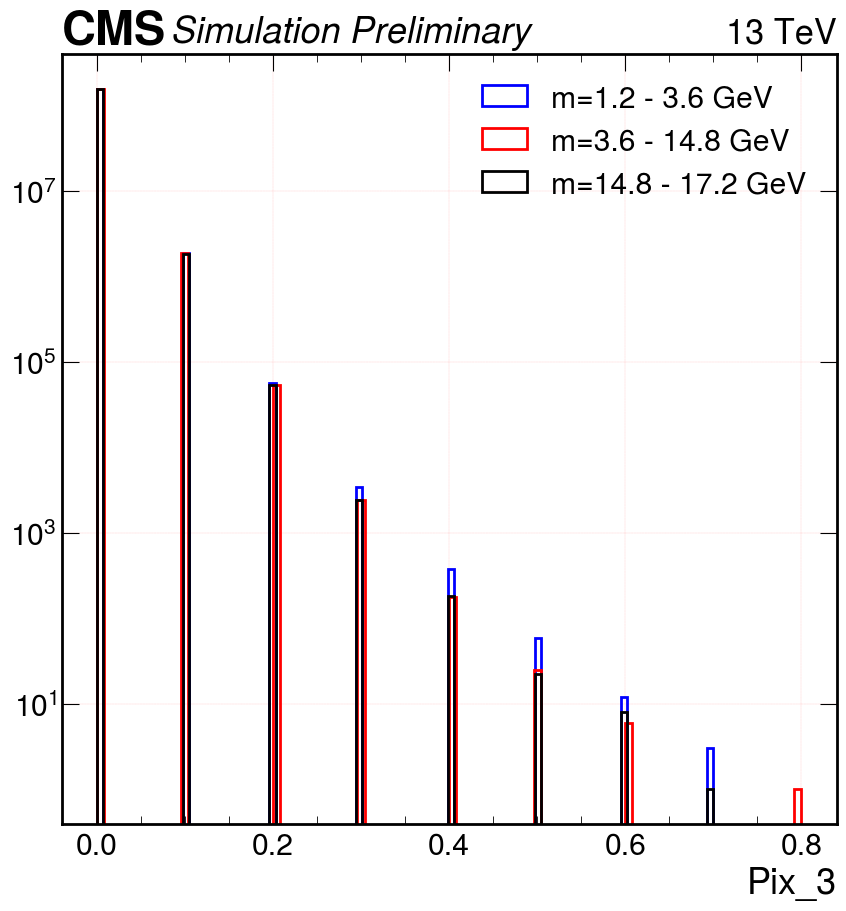

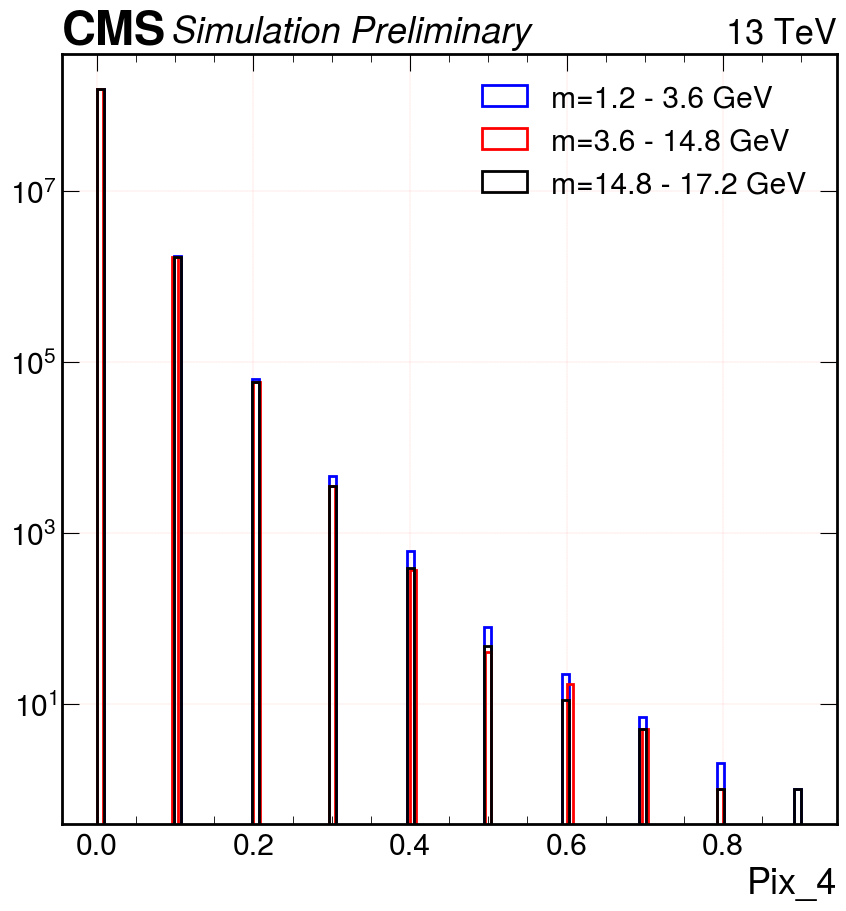

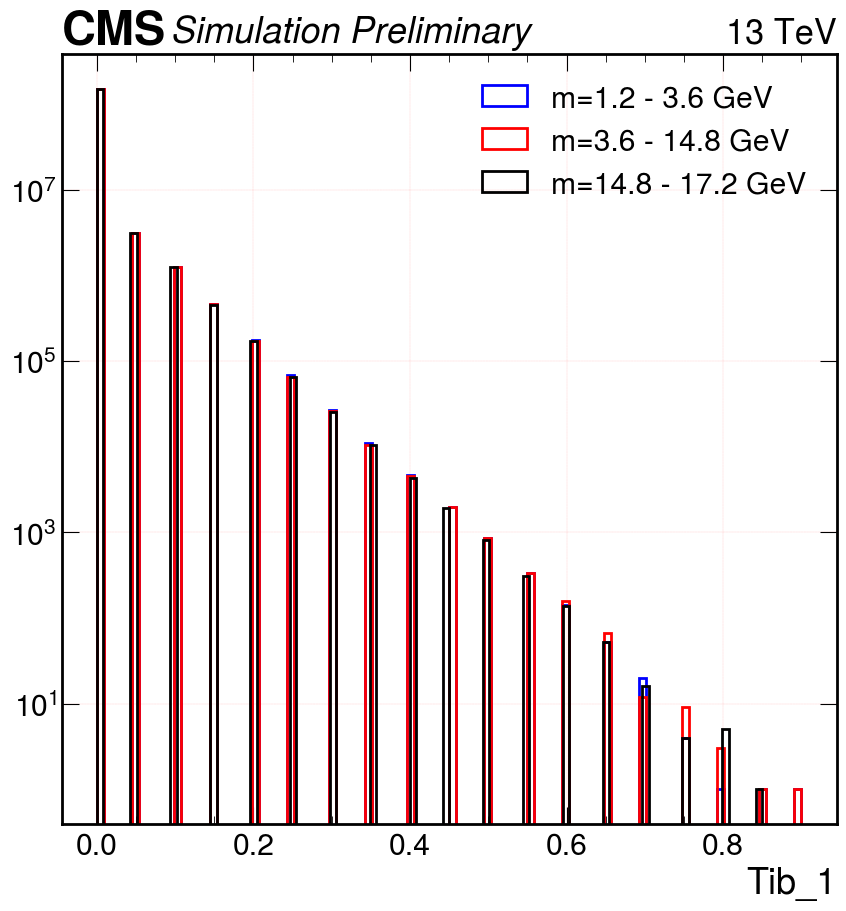

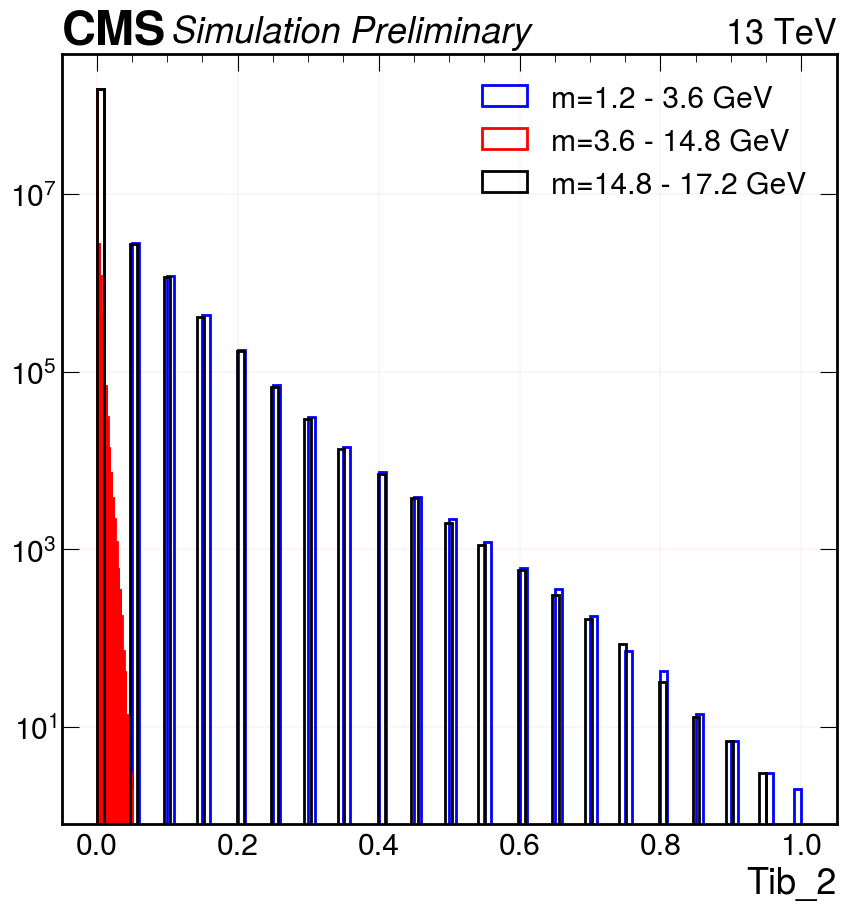

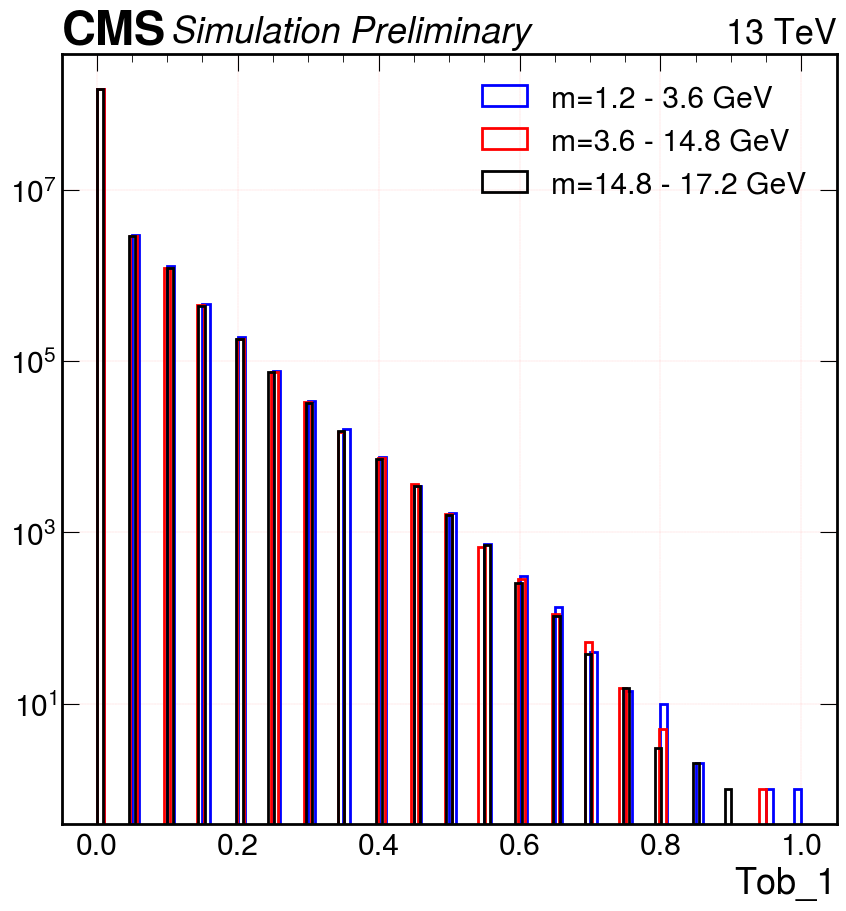

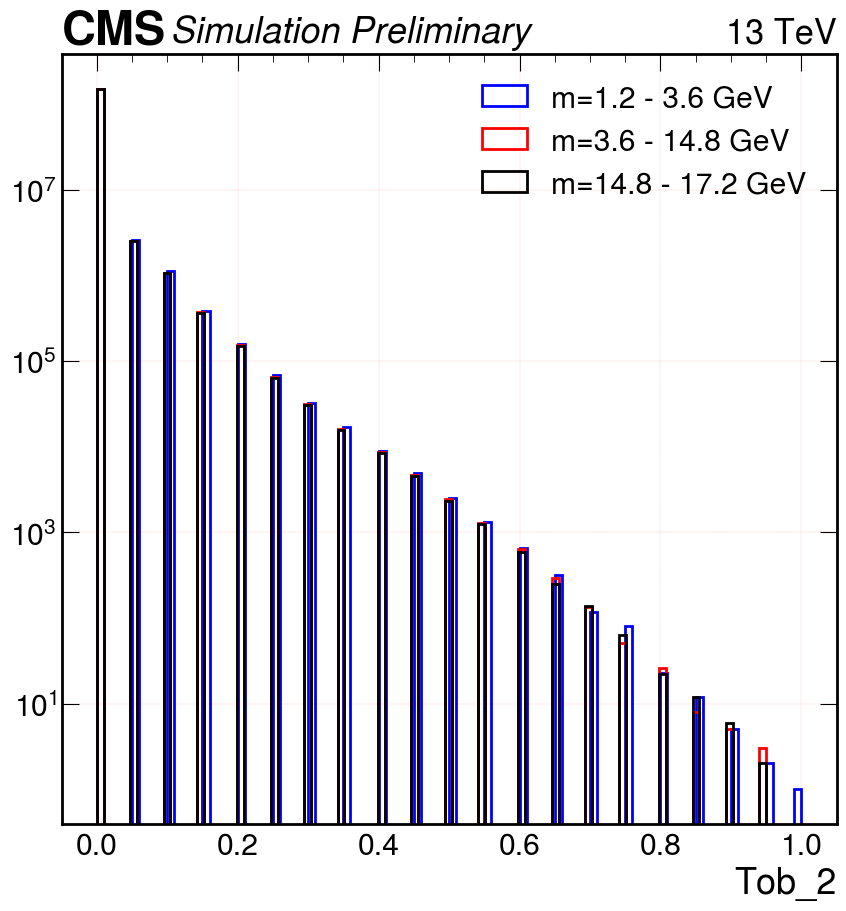

In [3]:
plot_scale_new('/pscratch/sd/b/bbbam/massreg_all_layers_data_to_check_scaling_m1p2To3p6.pkl', '/pscratch/sd/b/bbbam/massreg_all_layers_data_to_check_scaling_m3p6To14p8.pkl', '/pscratch/sd/b/bbbam/massreg_all_layers_data_to_check_scaling_m14To17p2.pkl')

In [15]:
# with open('/pscratch/sd/b/bbbam/massreg_all_layers_data_to_check_scaling_m3p6To14p8.pkl', 'rb') as f1:
#         u1 = pickle._Unpickler(f1)
#         u1.encoding = 'latin1'
#         data1 = u1.load()
    
# pt1 = data1["Traks_pt"]
# dz1 = data1["Tracks_dzsig"]
# d01 = data1["Tracks_d0sig"]
# ECAL_energy1 = data1["ECAL_energy"]
# HBHE_energy1 = data1["HBHE_energy"]
# Pix_11 = data1["Pix_1"]
# Pix_21 = data1["Pix_2"]
# Pix_31 = data1["Pix_3"]
# Pix_41 = data1["Pix_4"]
# Tib_11 = data1["Tib_1"]
# Tib_21 = data1["Tib_2"]
# Tob_11 = data1["Tob_1"]
# Tob_21 = data1["Tob_2"]

# with open('/pscratch/sd/b/bbbam/massreg_all_layers_data_to_check_scaling_m1p2To3p6.pkl', 'rb') as f2:
#     u2 = pickle._Unpickler(f2)
#     u2.encoding = 'latin1'
#     data2 = u2.load()
    
# pt2 = data2["Traks_pt"]
# dz2 = data2["Tracks_dzsig"]
# d02 = data2["Tracks_d0sig"]
# ECAL_energy2 = data2["ECAL_energy"]
# HBHE_energy2 = data2["HBHE_energy"]
# Pix_12 = data2["Pix_1"]
# Pix_22 = data2["Pix_2"]
# Pix_32 = data2["Pix_3"]
# Pix_42 = data2["Pix_4"]
# Tib_12 = data2["Tib_1"]
# Tib_22 = data2["Tib_2"]
# Tob_12 = data2["Tob_1"]
# Tob_22 = data2["Tob_2"]
    
    
# with open('/pscratch/sd/b/bbbam/massreg_all_layers_data_to_check_scaling_m14To17p2.pkl', 'rb') as f3:
#     u3 = pickle._Unpickler(f3)
#     u3.encoding = 'latin1'
#     data3 = u3.load()
    
# pt3 = data3["Traks_pt"]
# dz3 = data3["Tracks_dzsig"]
# d03 = data3["Tracks_d0sig"]
# ECAL_energy3 = data3["ECAL_energy"]
# HBHE_energy3 = data3["HBHE_energy"]
# Pix_13 = data3["Pix_1"]
# Pix_23 = data3["Pix_2"]
# Pix_33 = data3["Pix_3"]
# Pix_43 = data3["Pix_4"]
# Tib_13 = data3["Tib_1"]
# Tib_23 = data3["Tib_2"]
# Tob_13 = data3["Tob_1"]
# Tob_23 = data3["Tob_2"]

# print("DONE____")



5623

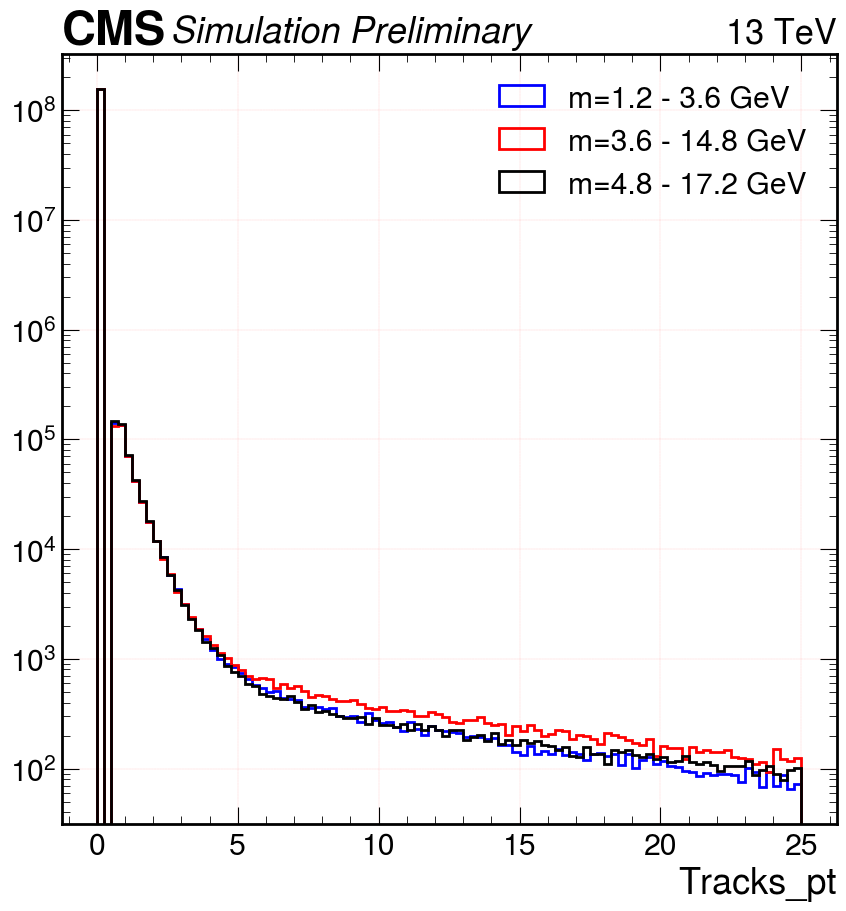

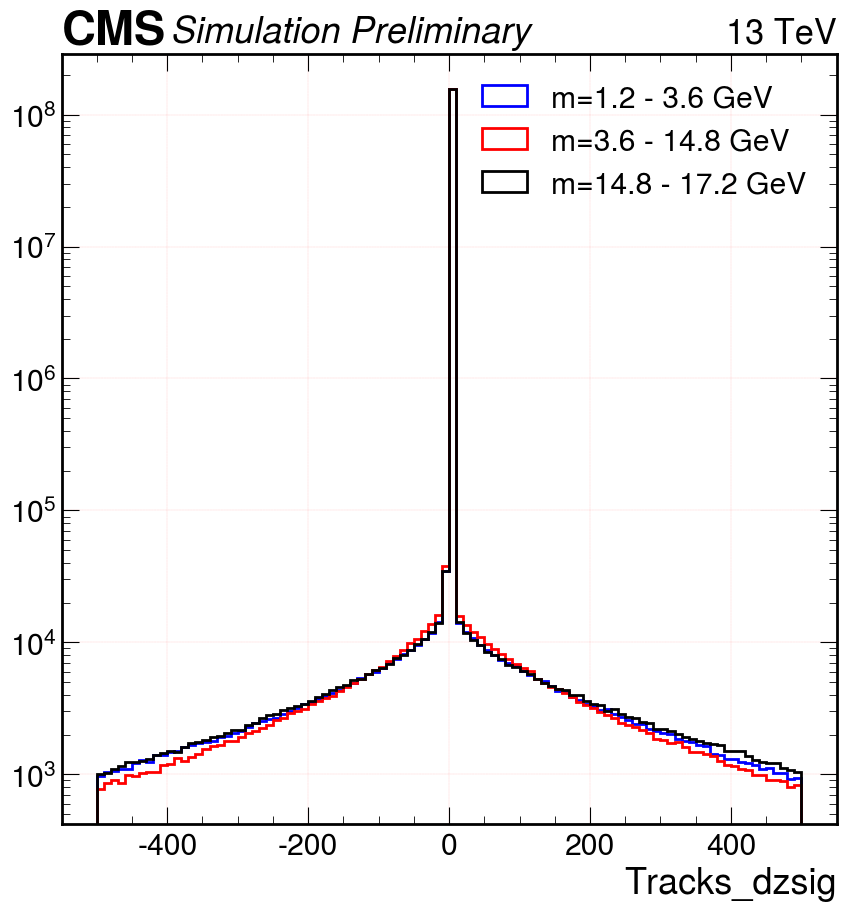

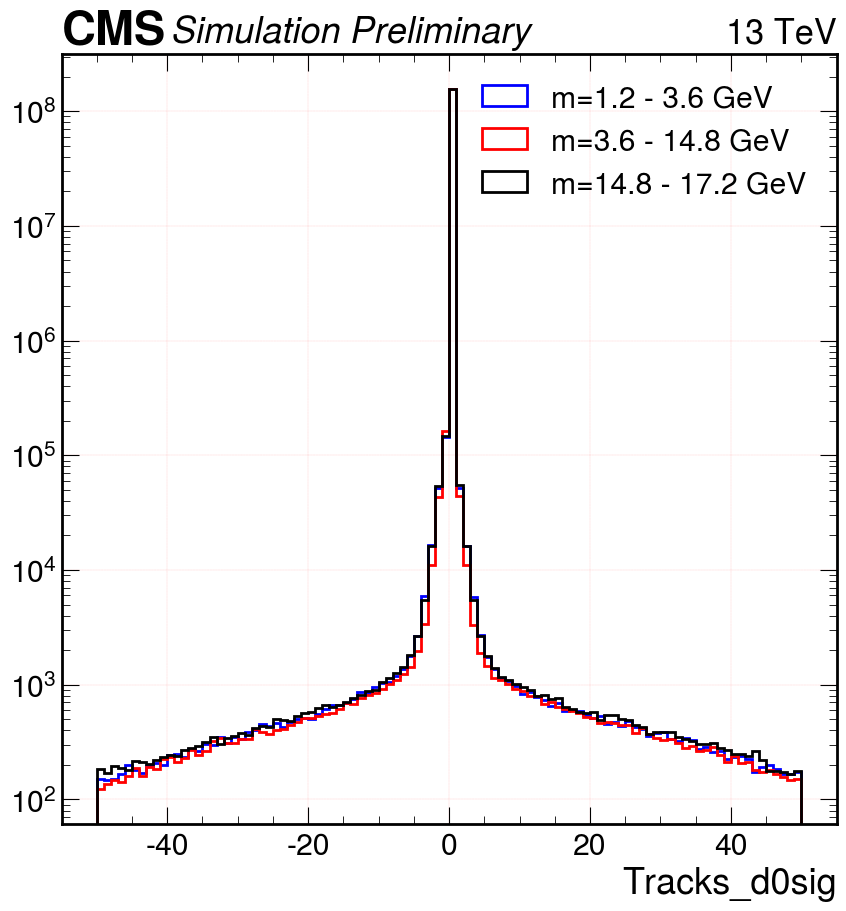

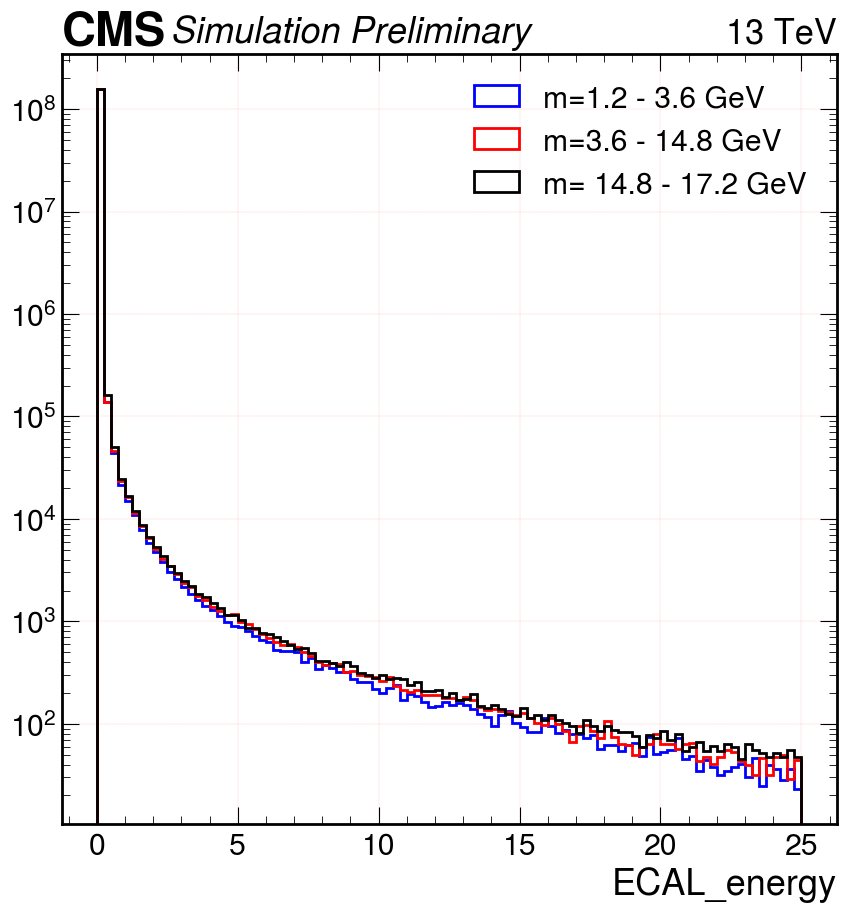

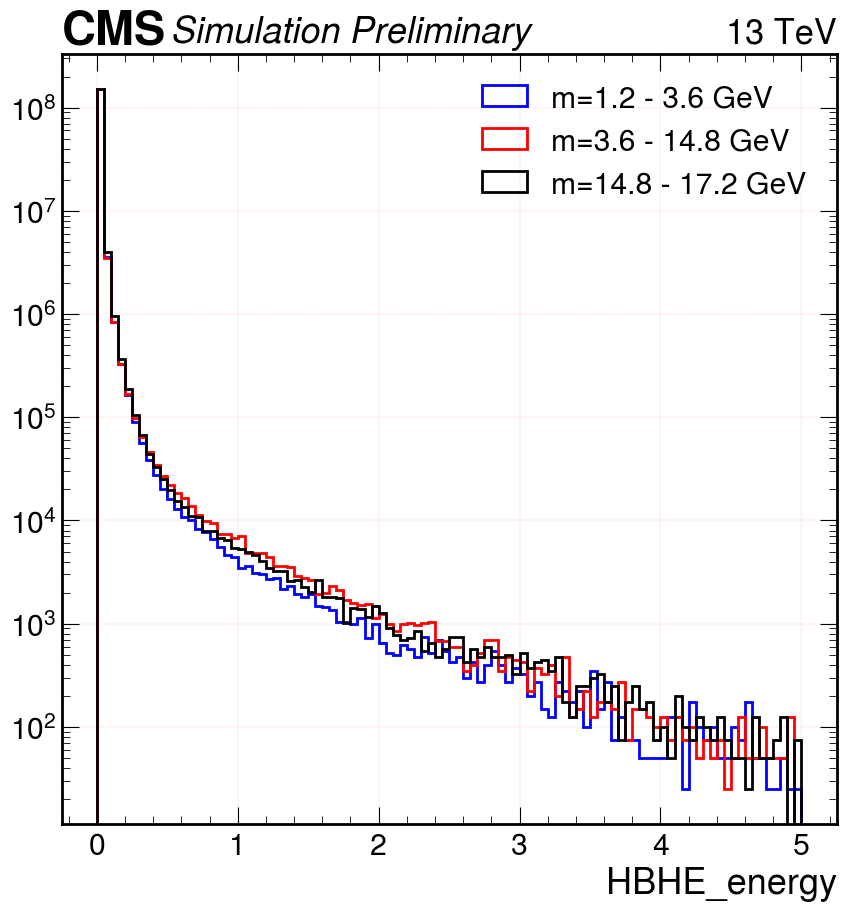

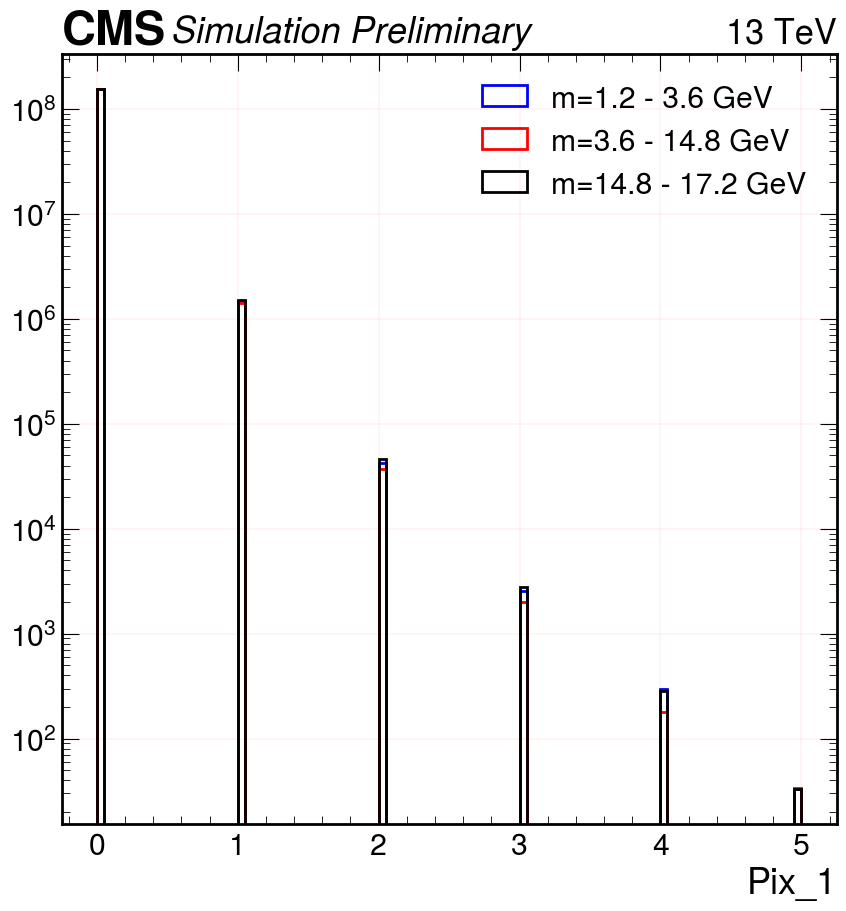

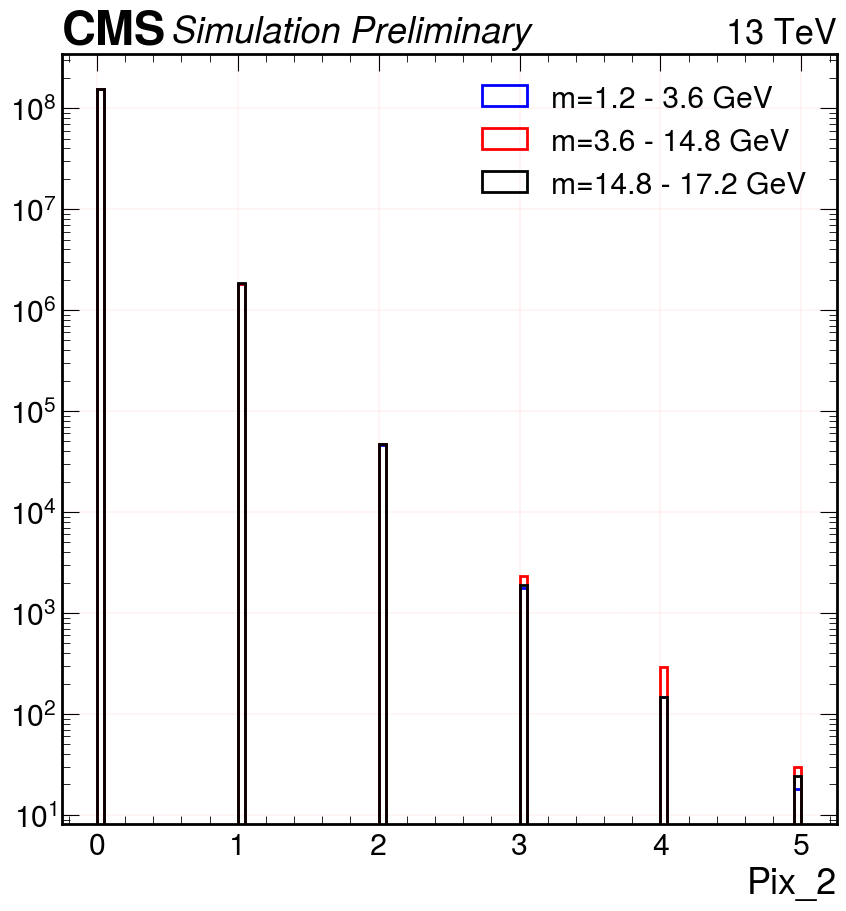

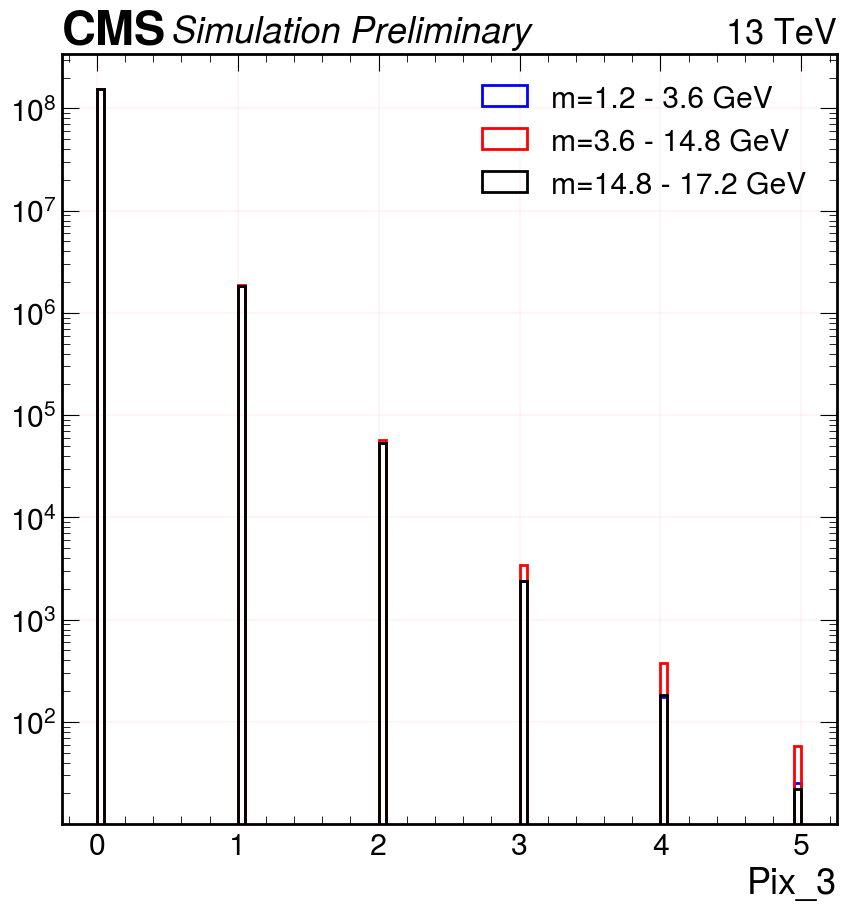

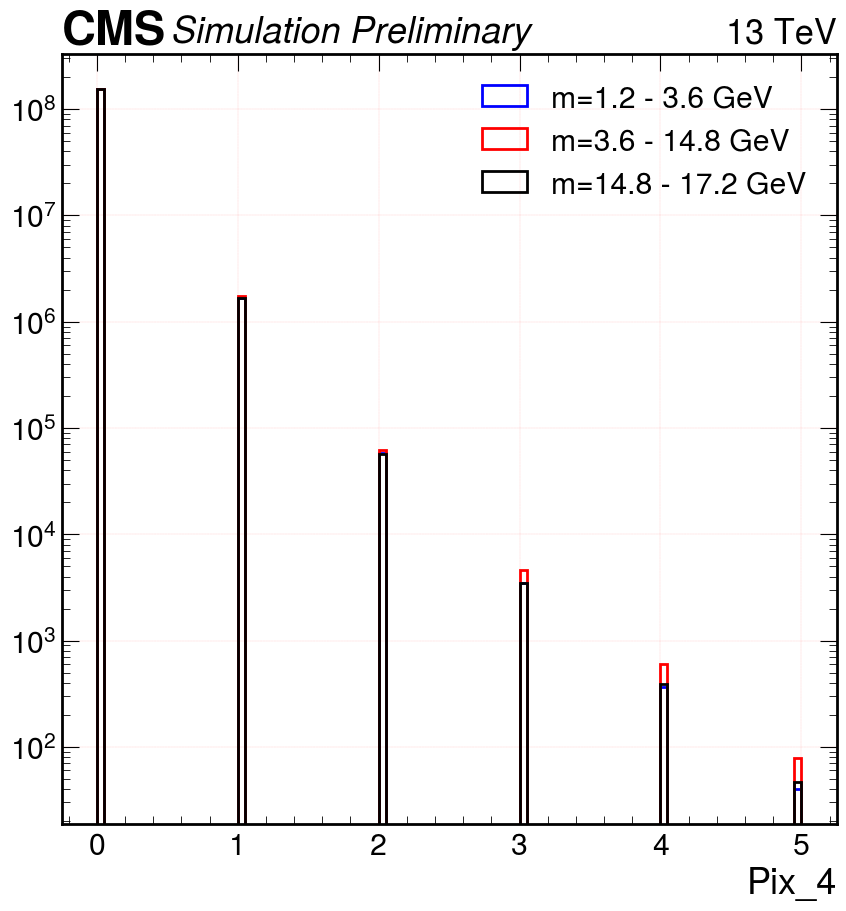

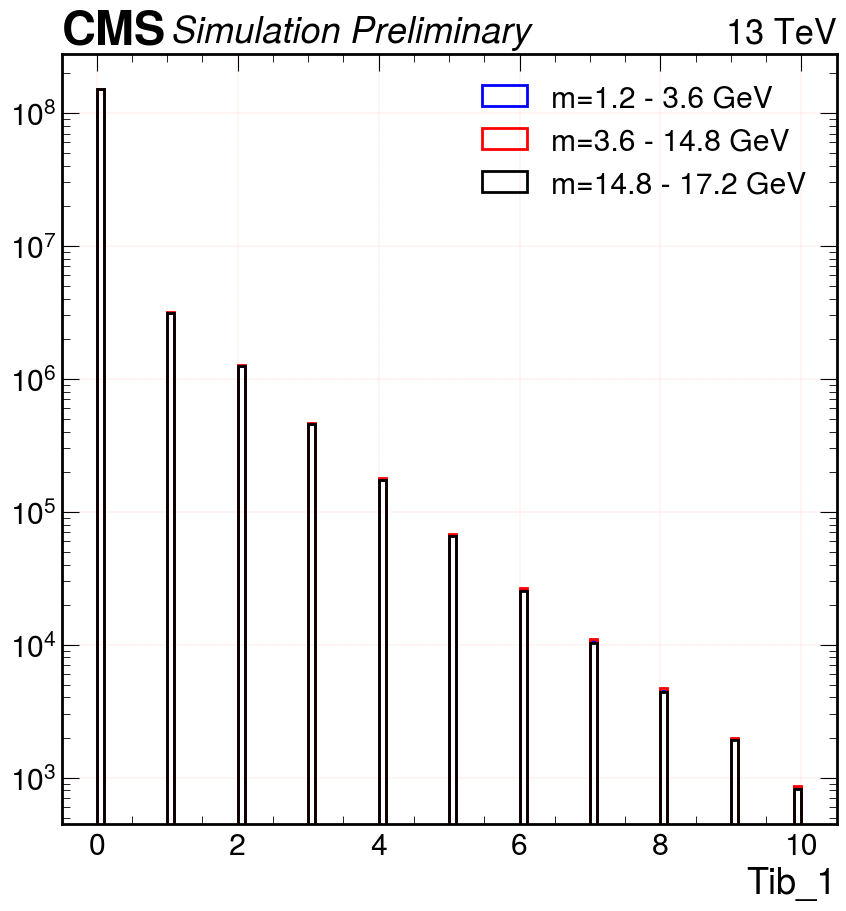

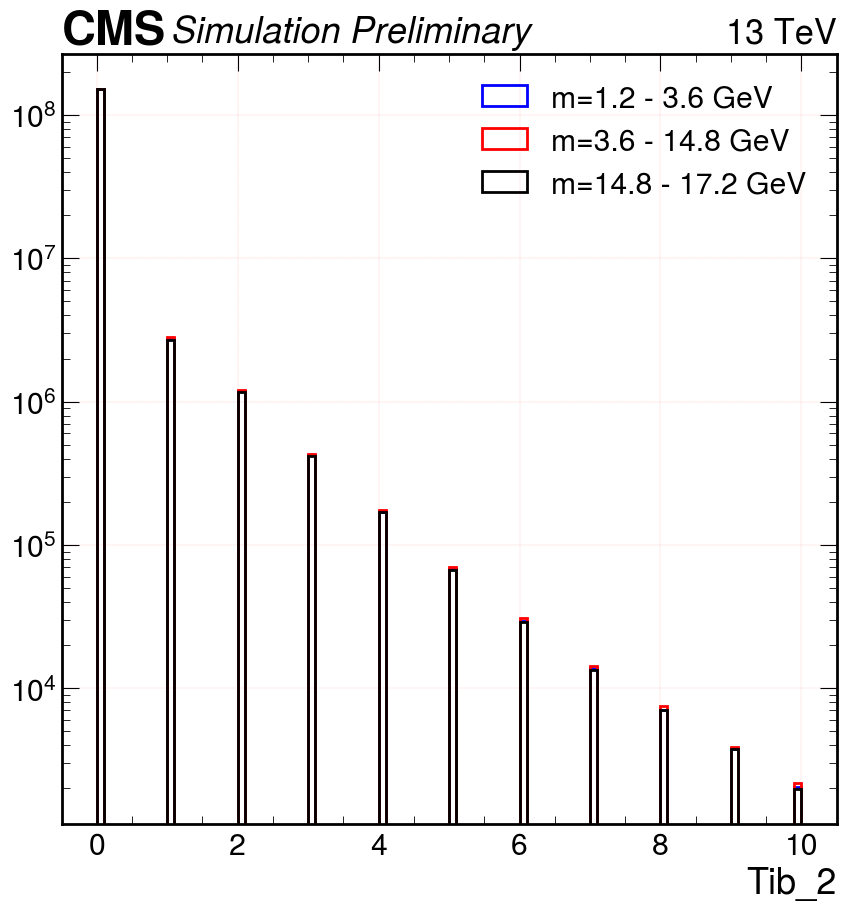

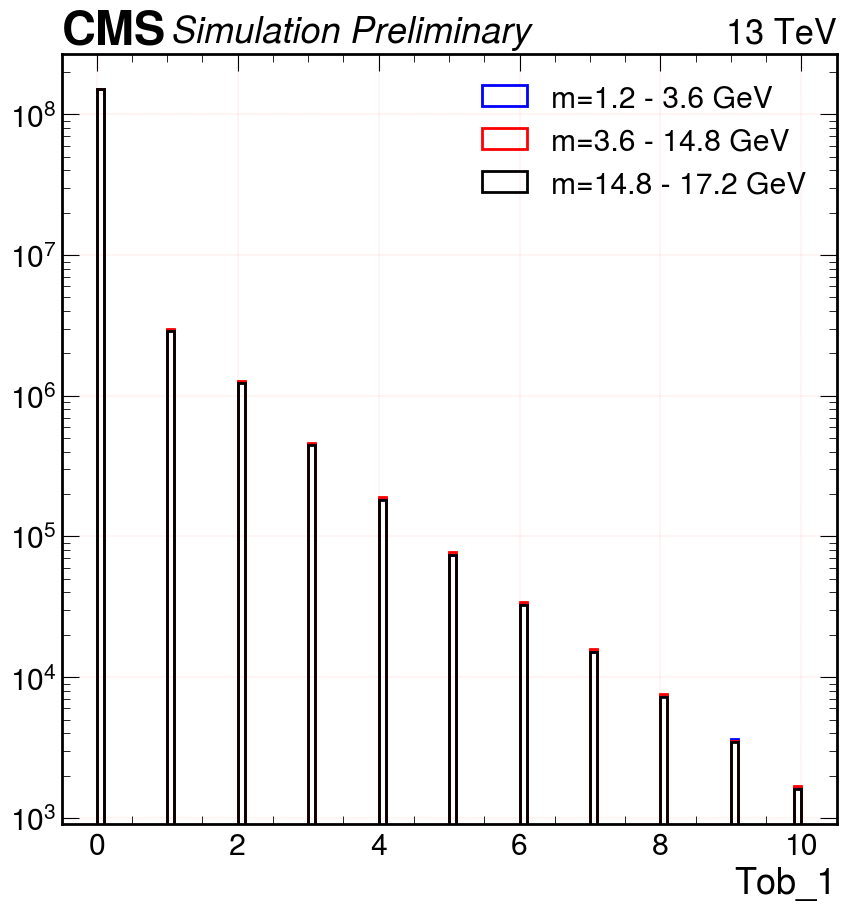

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation Preliminary'))

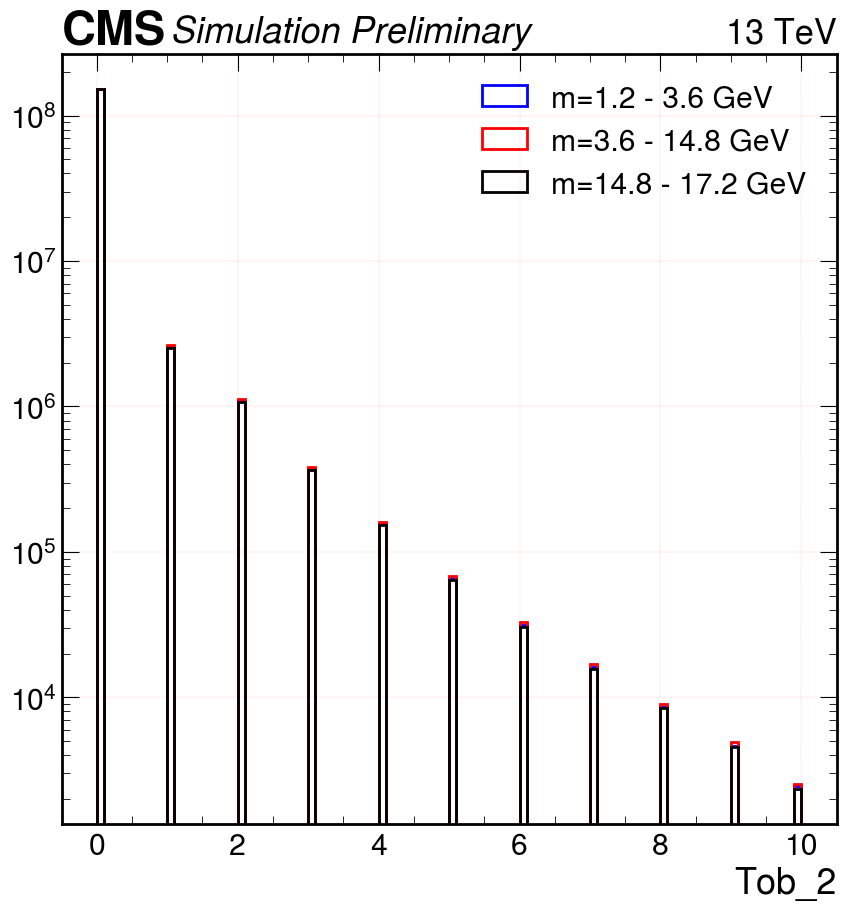

In [39]:
bins=100
fig, ax = plt.subplots()
plt.hist(pt1, histtype='step', range=(0,25),log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
plt.hist(pt2, histtype='step', range=(0,25),log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
plt.hist(pt3, histtype='step', range=(0,25),log=True,bins=bins, label='m=4.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
plt.grid(color='r', linestyle='--', linewidth=.1)
plt.xlabel('Tracks_pt')
plt.legend(loc='best')
hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
# if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
plt.show()

dz_range=(-500,500)
fig, ax = plt.subplots()
plt.hist(dz1, histtype='step',range=dz_range,log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
plt.hist(dz2, histtype='step',range=dz_range,log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
plt.hist(dz3, histtype='step',range=dz_range,log=True,bins=bins, label='m=14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
plt.grid(color='r', linestyle='--', linewidth=.1)
plt.xlabel('Tracks_dzsig')
plt.legend(loc='best')
hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
# if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
plt.show()

d0_range=(-50,50)
fig, ax = plt.subplots()
plt.hist(d01, histtype='step', range=d0_range, log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
plt.hist(d02, histtype='step',range=d0_range ,log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
plt.hist(d03, histtype='step',range=d0_range, log=True,bins=bins, label='m=14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
plt.grid(color='r', linestyle='--', linewidth=.1)
plt.xlabel('Tracks_d0sig')
plt.legend(loc='best')
hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
# if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
plt.show()

fig, ax = plt.subplots()
plt.hist(ECAL_energy1, histtype='step', range=(0,25),log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
plt.hist(ECAL_energy2, histtype='step', range=(0,25),log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
plt.hist(ECAL_energy3, histtype='step', range=(0,25),log=True,bins=bins, label='m= 14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
plt.grid(color='r', linestyle='--', linewidth=.1)
plt.xlabel('ECAL_energy')
plt.legend(loc='best')
hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
# if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
plt.show()

fig, ax = plt.subplots()
plt.hist(HBHE_energy1, histtype='step', range=(0,5),log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
plt.hist(HBHE_energy2, histtype='step', range=(0,5),log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
plt.hist(HBHE_energy3, histtype='step', range=(0,5),log=True,bins=bins, label='m=14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
plt.grid(color='r', linestyle='--', linewidth=.1)
plt.xlabel('HBHE_energy')
plt.legend(loc='best')
hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
# if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
plt.show()

pix_range=(0,5)
pix2_range=(0,10)
fig, ax = plt.subplots()
plt.hist(Pix_11, histtype='step', range=pix_range,log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
plt.hist(Pix_12, histtype='step', range=pix_range,log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
plt.hist(Pix_13, histtype='step', range=pix_range,log=True,bins=bins, label='m=14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
plt.grid(color='r', linestyle='--', linewidth=.1)
plt.xlabel('Pix_1')
plt.legend(loc='best')
hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
# if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
plt.show()

fig, ax = plt.subplots()
plt.hist(Pix_21, histtype='step',range=pix_range,log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
plt.hist(Pix_22, histtype='step',range=pix_range,log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
plt.hist(Pix_23, histtype='step',range=pix_range,log=True,bins=bins, label='m=14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
plt.grid(color='r', linestyle='--', linewidth=.1)
plt.xlabel('Pix_2')
plt.legend(loc='best')
hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
# if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
plt.show()

fig, ax = plt.subplots()
plt.hist(Pix_31, histtype='step',range=pix_range, log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
plt.hist(Pix_32, histtype='step',range=pix_range, log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
plt.hist(Pix_33, histtype='step',range=pix_range, log=True,bins=bins, label='m=14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
plt.grid(color='r', linestyle='--', linewidth=.1)
plt.xlabel('Pix_3')
plt.legend(loc='best')
hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
# if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
plt.show()

fig, ax = plt.subplots()
plt.hist(Pix_41, histtype='step',range=pix_range, log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
plt.hist(Pix_42, histtype='step',range=pix_range, log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
plt.hist(Pix_43, histtype='step',range=pix_range, log=True,bins=bins, label='m=14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
plt.grid(color='r', linestyle='--', linewidth=.1)
plt.xlabel('Pix_4')
plt.legend(loc='best')
hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
# if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
plt.show()

fig, ax = plt.subplots()
plt.hist(Tib_11, histtype='step',range=pix2_range, log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
plt.hist(Tib_12, histtype='step',range=pix2_range, log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
plt.hist(Tib_13, histtype='step',range=pix2_range, log=True,bins=bins, label='m=14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
plt.grid(color='r', linestyle='--', linewidth=.1)
plt.xlabel('Tib_1')
plt.legend(loc='best')
hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
# if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
plt.show()

fig, ax = plt.subplots()
plt.hist(Tib_21, histtype='step',range=pix2_range, log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
plt.hist(Tib_22, histtype='step',range=pix2_range, log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
plt.hist(Tib_23, histtype='step',range=pix2_range, log=True,bins=bins, label='m=14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
plt.grid(color='r', linestyle='--', linewidth=.1)
plt.xlabel('Tib_2')
plt.legend(loc='best')
hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
# if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
plt.show()

fig, ax = plt.subplots()
plt.hist(Tob_11, histtype='step',range=pix2_range, log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
plt.hist(Tob_12, histtype='step',range=pix2_range, log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
plt.hist(Tob_13, histtype='step',range=pix2_range, log=True,bins=bins, label='m=14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
plt.grid(color='r', linestyle='--', linewidth=.1)
plt.xlabel('Tob_1')
plt.legend(loc='best')
hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
# if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
plt.show()

fig, ax = plt.subplots()
plt.hist(Tob_21, histtype='step',range=pix2_range, log=True,bins=bins, label='m=1.2 - 3.6 GeV', linestyle='-', color='blue', linewidth=2)
plt.hist(Tob_22, histtype='step',range=pix2_range, log=True,bins=bins, label='m=3.6 - 14.8 GeV', linestyle='-', color='red', linewidth=2)
plt.hist(Tob_23, histtype='step',range=pix2_range, log=True,bins=bins, label='m=14.8 - 17.2 GeV', linestyle='-', color='black', linewidth=2)
plt.grid(color='r', linestyle='--', linewidth=.1)
plt.xlabel('Tob_2')
plt.legend(loc='best')
hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
# if save: plt.savefig('%s/%d_mtru_mpred_hist_full.png'%(out_dir, epoch), bbox_inches='tight',dpi=300, facecolor = "w")
# plt.show()